In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states 
from tools.ae_v1 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-05-25 19:46:32.968113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-05-25 19:46:32.968396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 19:46:33.005189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 19:46:33.005526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 19:46:33.005797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 19:46:33.006065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '000'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_noiseSearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[1.04895428e-01, 1.00677975e-01, 1.01455748e-01, 1.07038975e-01,
        1.15524963e-01, 1.24498643e-01, 1.32090986e-01, 1.37528211e-01,
        1.41156599e-01, 1.44102126e-01, 1.47524297e-01, 1.51665181e-01,
        1.54968590e-01, 1.54004678e-01, 1.45411506e-01, 1.28925756e-01,
        1.08675964e-01, 9.11559835e-02, 8.14666823e-02, 8.09827968e-02,
        8.77058581e-02, 9.81689095e-02, 1.08952150e-01, 1.17303252e-01,
        1.21563986e-01, 1.21806026e-01, 1.19666912e-01, 1.17023595e-01,
        1.14840910e-01, 1.13341480e-01, 1.12681627e-01, 1.12990953e-01,
        1.14061654e-01, 1.15491308e-01, 1.17183998e-01, 1.19535834e-01,
        1.23133965e-01, 1.28426880e-01, 1.35574624e-01, 1.44235477e-01,
        1.52901426e-01, 1.58540055e-01, 1.57794520e-01, 1.49408311e-01,
        1.35650888e-01, 1.21296138e-01, 1.11013673e-01, 1.07349895e-01,
        1.10332102e-01, 1.18103951e-01, 1.27738327e-01, 1.36243924e-01,
        1.41599804e-01, 1.43402293e-01, 1.42630473e-01, 1.407220

# Autoencoder

In [22]:
# setting up training params
learning_rate_list = [1e-3, 1e-4]
epochs = 200
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.2

# stddev = fRMS*timeMeanofSpaceRMS
contractive_lmda = 0.0
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [23]:
# all_data = all_data[0:370001]
# boundary_idx_arr[0] = 370001

In [24]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = (num_elems_pre_indexing+skip_factor-1)//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [25]:
boundary_idx_arr

array([250013])

In [26]:
all_data.shape

(250013, 64)

In [27]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [28]:
#

In [29]:
# Initialize network
latent_space_dim = 17
enc_layers = [128, 96, 64, 48, 32, 24, 16, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
for i in range(len(enc_layers)):
    if latent_space_dim < enc_layers[-i-1]:
        enc_layers = enc_layers[0:-i]
        break
    if i == len(enc_layers)-1:
        enc_layers = []
dec_layers = enc_layers[::-1]
# enc_layers = [16, 8, 8]
# dec_layers = [8, 8, 16]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [30]:
#

In [31]:
def optim_func(
        x, # [fRMS, lambda_reg]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    test_mse = trainAE_and_return_testError(
        x, # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    return test_mse

In [32]:
fRMS_bounds = (0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = (1e-7, 1e-3, "log-uniform")
n_calls = 25
acq_func = "EI"
n_initial_points = 5

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0032 - NMSE: 0.0287 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 1.4354 - tot_time: 0h 0m 31.9s

Epoch 1: val_mse improved from inf to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 32s 10ms/step - loss: 0.0037 - mse: 0.0032 - NMSE: 0.0287 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 1.4351 - val_loss: 0.0010 - val_mse: 5.53

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 5.1062e-04 - mse: 2.4110e-04 - NMSE: 0.0022 - real_MSE: 2.4110e-04 - params_MSE: nan - ls_jacobian_norm: 1.0257 - val_loss: 4.7924e-04 - val_mse: 2.1352e-04 - val_NMSE: 0.0019 - val_real_MSE: 2.1352e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3126/3126 [==============================] - ETA: 0s - loss: 4.9713e-04 - mse: 2.3480e-04 - NMSE: 0.0021 - real_MSE: 2.3480e-04 - params_MSE: nan - ls_jacobian_norm: 1.0382 - tot_time: 0h 5m 20.4s

Epoch 11: val_mse did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 4.9713e-04 - mse: 2.348

Epoch 21/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.4308e-04 - mse: 2.0878e-04 - NMSE: 0.0019 - real_MSE: 2.0878e-04 - params_MSE: nan - ls_jacobian_norm: 1.1220 - tot_time: 0h 10m 14.8s

Epoch 21: val_mse did not improve from 0.00019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 4.4309e-04 - mse: 2.0878e-04 - NMSE: 0.0019 - real_MSE: 2.0878e-04 - params_MSE: nan - ls_jacobian_norm: 1.1220 - val_loss: 4.8784e-04 - val_mse: 2.5401e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.5401e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.4138e-04 - mse: 2.0809e-04 - NMSE: 0.0019 - real_MSE: 2.0809e-04 - params_MSE: nan - ls_jacobian_norm: 1.1288 - tot_time: 0h 10m 44.6s

Epoch 22: val_mse did not improve from 0.

Epoch 32/200
3119/3126 [============================>.] - ETA: 0s - loss: 4.2686e-04 - mse: 1.9931e-04 - NMSE: 0.0018 - real_MSE: 1.9931e-04 - params_MSE: nan - ls_jacobian_norm: 1.1736 - tot_time: 0h 15m 42.6s

Epoch 32: val_mse did not improve from 0.00019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 4.2684e-04 - mse: 1.9929e-04 - NMSE: 0.0018 - real_MSE: 1.9929e-04 - params_MSE: nan - ls_jacobian_norm: 1.1736 - val_loss: 4.2959e-04 - val_mse: 2.0227e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0227e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
3122/3126 [============================>.] - ETA: 0s - loss: 4.2561e-04 - mse: 1.9838e-04 - NMSE: 0.0018 - real_MSE: 1.9838e-04 - params_MSE: nan - ls_jacobian_norm: 1.1770 - tot_time: 0h 16m 12.8s

Epoch 33: val_mse did not improve from 0.

Epoch 43/200
3122/3126 [============================>.] - ETA: 0s - loss: 4.1701e-04 - mse: 1.9178e-04 - NMSE: 0.0017 - real_MSE: 1.9178e-04 - params_MSE: nan - ls_jacobian_norm: 1.1991 - tot_time: 0h 21m 14.4s

Epoch 43: val_mse did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.1700e-04 - mse: 1.9178e-04 - NMSE: 0.0017 - real_MSE: 1.9178e-04 - params_MSE: nan - ls_jacobian_norm: 1.1991 - val_loss: 4.3044e-04 - val_mse: 2.0530e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0530e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
3119/3126 [============================>.] - ETA: 0s - loss: 4.1829e-04 - mse: 1.9321e-04 - NMSE: 0.0017 - real_MSE: 1.9321e-04 - params_MSE: nan - ls_jacobian_norm: 1.2042 - tot_time: 0h 21m 44.6s

Epoch 44: val_mse did not improve from 0

Epoch 6/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.1967e-04 - mse: 9.1183e-05 - NMSE: 8.2064e-04 - real_MSE: 9.1183e-05 - params_MSE: nan - ls_jacobian_norm: 1.0352 - tot_time: 0h 26m 16.5s

Epoch 6: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.1967e-04 - mse: 9.1183e-05 - NMSE: 8.2064e-04 - real_MSE: 9.1183e-05 - params_MSE: nan - ls_jacobian_norm: 1.0352 - val_loss: 2.8684e-04 - val_mse: 5.8258e-05 - val_NMSE: 5.2431e-04 - val_real_MSE: 5.8258e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.1893e-04 - mse: 9.0325e-05 - NMSE: 8.1292e-04 - real_MSE: 9.0325e-05 - params_MSE: nan - ls_jacobian_norm: 1.0258 - tot_time: 0h 26m 46.6s

Epoch 7: val_mse improved f

Epoch 16/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.1569e-04 - mse: 8.7084e-05 - NMSE: 7.8375e-04 - real_MSE: 8.7084e-05 - params_MSE: nan - ls_jacobian_norm: 0.9912 - tot_time: 0h 31m 19.0s

Epoch 16: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.1569e-04 - mse: 8.7083e-05 - NMSE: 7.8374e-04 - real_MSE: 8.7083e-05 - params_MSE: nan - ls_jacobian_norm: 0.9912 - val_loss: 2.8100e-04 - val_mse: 5.2394e-05 - val_NMSE: 4.7154e-04 - val_real_MSE: 5.2394e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.1547e-04 - mse: 8.6918e-05 - NMSE: 7.8226e-04 - real_MSE: 8.6918e-05 - params_MSE: nan - ls_jacobian_norm: 0.9899 - tot_time: 0h 31m 49.2s

Epoch 17: val_mse did no

3122/3126 [============================>.] - ETA: 0s - loss: 3.1380e-04 - mse: 8.5878e-05 - NMSE: 7.7289e-04 - real_MSE: 8.5878e-05 - params_MSE: nan - ls_jacobian_norm: 0.9863 - tot_time: 0h 36m 20.2s

Epoch 26: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 3.1380e-04 - mse: 8.5877e-05 - NMSE: 7.7288e-04 - real_MSE: 8.5877e-05 - params_MSE: nan - ls_jacobian_norm: 0.9863 - val_loss: 2.7948e-04 - val_mse: 5.1593e-05 - val_NMSE: 4.6433e-04 - val_real_MSE: 5.1593e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.1362e-04 - mse: 8.5766e-05 - NMSE: 7.7189e-04 - real_MSE: 8.5766e-05 - params_MSE: nan - ls_jacobian_norm: 0.9863 - tot_time: 0h 36m 50.6s

Epoch 27: val_mse did not improve from

3126/3126 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.6715 - tot_time: 0h 1m 26.5s

Epoch 3: val_mse improved from 0.00147 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0082 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.6715 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0117 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0080 - mse: 0.0012 - NMSE: 0.0112 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian

Epoch 14/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0078 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.7712 - tot_time: 0h 6m 50.8s

Epoch 14: val_mse improved from 0.00114 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0078 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.7712 - val_loss: 0.0077 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0078 - mse: 0.0011 - NMSE: 0.0102 - real_MSE: 0.0011 - params_MSE: na

3122/3126 [============================>.] - ETA: 0s - loss: 0.0077 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.7887 - tot_time: 0h 12m 16.8s

Epoch 25: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0077 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.7886 - val_loss: 0.0077 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0077 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.7886 - tot_time: 0h 12m 46.9s

Epoch 26: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/T

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0077 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.8014 - val_loss: 0.0078 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0077 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.8017 - tot_time: 0h 18m 18.3s

Epoch 37: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0077 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 -

Epoch 9/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 8.6573e-04 - NMSE: 0.0078 - real_MSE: 8.6573e-04 - params_MSE: nan - ls_jacobian_norm: 1.7758 - tot_time: 0h 23m 20.1s

Epoch 9: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0075 - mse: 8.6573e-04 - NMSE: 0.0078 - real_MSE: 8.6573e-04 - params_MSE: nan - ls_jacobian_norm: 1.7758 - val_loss: 0.0075 - val_mse: 8.5250e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5250e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 8.6484e-04 - NMSE: 0.0078 - real_MSE: 8.6484e-04 - params_MSE: nan - ls_jacobian_norm: 1.7768 - tot_time: 0h 23m 50.3s

Epoch 10: val_mse did not improve from 0.00085
 - saving l

Epoch 20/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 8.6238e-04 - NMSE: 0.0078 - real_MSE: 8.6238e-04 - params_MSE: nan - ls_jacobian_norm: 1.7805 - tot_time: 0h 28m 52.4s

Epoch 20: val_mse did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0075 - mse: 8.6234e-04 - NMSE: 0.0078 - real_MSE: 8.6234e-04 - params_MSE: nan - ls_jacobian_norm: 1.7805 - val_loss: 0.0075 - val_mse: 8.5081e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5081e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 8.6217e-04 - NMSE: 0.0078 - real_MSE: 8.6217e-04 - params_MSE: nan - ls_jacobian_norm: 1.7813 - tot_time: 0h 29m 22.3s

Epoch 21: val_mse improved from 0.00084 to 0.00084, savi

Epoch 31/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 8.5989e-04 - NMSE: 0.0077 - real_MSE: 8.5989e-04 - params_MSE: nan - ls_jacobian_norm: 1.7845 - tot_time: 0h 34m 10.7s

Epoch 31: val_mse did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0075 - mse: 8.5991e-04 - NMSE: 0.0077 - real_MSE: 8.5991e-04 - params_MSE: nan - ls_jacobian_norm: 1.7845 - val_loss: 0.0075 - val_mse: 8.4704e-04 - val_NMSE: 0.0076 - val_real_MSE: 8.4704e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 8.5991e-04 - NMSE: 0.0077 - real_MSE: 8.5991e-04 - params_MSE: nan - ls_jacobian_norm: 1.7846 - tot_time: 0h 34m 40.1s

Epoch 32: val_mse did not improve from 0.00083
 - saving 

Epoch 3/200
3120/3126 [============================>.] - ETA: 0s - loss: 5.0102e-04 - mse: 2.8233e-04 - NMSE: 0.0025 - real_MSE: 2.8233e-04 - params_MSE: nan - ls_jacobian_norm: 0.9390 - tot_time: 0h 1m 34.0s

Epoch 3: val_mse improved from 0.00041 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 5.0097e-04 - mse: 2.8229e-04 - NMSE: 0.0025 - real_MSE: 2.8229e-04 - params_MSE: nan - ls_jacobian_norm: 0.9390 - val_loss: 5.6140e-04 - val_mse: 3.4827e-04 - val_NMSE: 0.0031 - val_real_MSE: 3.4827e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.4258e-04 - mse: 2.3544e-04 - NMSE: 

Epoch 13/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.9117e-04 - mse: 1.5030e-04 - NMSE: 0.0014 - real_MSE: 1.5030e-04 - params_MSE: nan - ls_jacobian_norm: 0.9879 - tot_time: 0h 6m 34.1s

Epoch 13: val_mse improved from 0.00017 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.9115e-04 - mse: 1.5028e-04 - NMSE: 0.0014 - real_MSE: 1.5028e-04 - params_MSE: nan - ls_jacobian_norm: 0.9879 - val_loss: 2.9887e-04 - val_mse: 1.5950e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5950e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3121/3126 [============================>.] - ETA: 0s - loss: 2.8459e-04 - mse: 1.4680e-04 - NMSE

Epoch 24/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.5049e-04 - mse: 1.2825e-04 - NMSE: 0.0012 - real_MSE: 1.2825e-04 - params_MSE: nan - ls_jacobian_norm: 1.0343 - tot_time: 0h 12m 0.4s

Epoch 24: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.5049e-04 - mse: 1.2825e-04 - NMSE: 0.0012 - real_MSE: 1.2825e-04 - params_MSE: nan - ls_jacobian_norm: 1.0343 - val_loss: 3.1735e-04 - val_mse: 1.9545e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9545e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3126/3126 [==============================] - ETA: 0s - loss: 2.4899e-04 - mse: 1.2745e-04 - NMSE: 0.0011 - real_MSE: 1.2745e-04 - params_MSE: nan - ls_jacobian_norm: 1.0390 - tot_time: 0h 12m 30.5s

Epoch 25: val_mse did not improve from 0.

Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.6460e-04 - mse: 3.8252e-05 - NMSE: 3.4427e-04 - real_MSE: 3.8252e-05 - params_MSE: nan - ls_jacobian_norm: 0.8770 - tot_time: 0h 17m 4.5s

Epoch 4: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.6460e-04 - mse: 3.8252e-05 - NMSE: 3.4426e-04 - real_MSE: 3.8252e-05 - params_MSE: nan - ls_jacobian_norm: 0.8770 - val_loss: 1.6535e-04 - val_mse: 3.9010e-05 - val_NMSE: 3.5108e-04 - val_real_MSE: 3.9010e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.6323e-04 - mse: 3.6907e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.5687e-04 - mse: 3.1630e-05 - NMSE: 2.8467e-04 - real_MSE: 3.1630e-05 - params_MSE: nan - ls_jacobian_norm: 0.8004 - val_loss: 1.5639e-04 - val_mse: 3.1247e-05 - val_NMSE: 2.8122e-04 - val_real_MSE: 3.1247e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.5626e-04 - mse: 3.1201e-05 - NMSE: 2.8081e-04 - real_MSE: 3.1201e-05 - params_MSE: nan - ls_jacobian_norm: 0.7975 - tot_time: 0h 22m 10.5s

Epoch 14: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.5626e-

Epoch 24/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.5223e-04 - mse: 2.9016e-05 - NMSE: 2.6114e-04 - real_MSE: 2.9016e-05 - params_MSE: nan - ls_jacobian_norm: 0.7869 - tot_time: 0h 27m 21.4s

Epoch 24: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.5223e-04 - mse: 2.9015e-05 - NMSE: 2.6114e-04 - real_MSE: 2.9015e-05 - params_MSE: nan - ls_jacobian_norm: 0.7869 - val_loss: 1.5366e-04 - val_mse: 3.0521e-05 - val_NMSE: 2.7469e-04 - val_real_MSE: 3.0521e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.5195e-04 - mse: 2.8908e-05 - NMSE: 2.6017e-04 - real_MSE: 2.8908e-05 - params_MSE: nan - ls_jacobian_norm: 0.7868 - tot_time: 0h 27m 52.2s

Epoch 25: val_mse did no

Epoch 35/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.4937e-04 - mse: 2.7909e-05 - NMSE: 2.5118e-04 - real_MSE: 2.7909e-05 - params_MSE: nan - ls_jacobian_norm: 0.7904 - tot_time: 0h 33m 3.5s

Epoch 35: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.4937e-04 - mse: 2.7911e-05 - NMSE: 2.5119e-04 - real_MSE: 2.7911e-05 - params_MSE: nan - ls_jacobian_norm: 0.7904 - val_loss: 1.5040e-04 - val_mse: 2.9014e-05 - val_NMSE: 2.6113e-04 - val_real_MSE: 2.9014e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.4909e-04 - mse: 2.7772e-05 - NMSE: 2.4994e-04 - real_MSE: 2.7772e-05 - params_MSE: nan - ls_jacobian_norm: 0.7909 - tot_time: 0h 33m 33.4s

Epoch 36: val_mse improve

Epoch 2/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0018 - mse: 4.5138e-04 - NMSE: 0.0041 - real_MSE: 4.5138e-04 - params_MSE: nan - ls_jacobian_norm: 1.1076 - tot_time: 0h 1m 4.1s

Epoch 2: val_mse improved from 0.00057 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0018 - mse: 4.5138e-04 - NMSE: 0.0041 - real_MSE: 4.5138e-04 - params_MSE: nan - ls_jacobian_norm: 1.1075 - val_loss: 0.0016 - val_mse: 3.9612e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9612e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 3.4541e-04 - NMSE: 0.0031 - real_MSE

3121/3126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 2.0733e-04 - NMSE: 0.0019 - real_MSE: 2.0733e-04 - params_MSE: nan - ls_jacobian_norm: 1.2322 - tot_time: 0h 6m 5.5s

Epoch 12: val_mse did not improve from 0.00023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0010 - mse: 2.0736e-04 - NMSE: 0.0019 - real_MSE: 2.0736e-04 - params_MSE: nan - ls_jacobian_norm: 1.2323 - val_loss: 0.0011 - val_mse: 2.8598e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.8598e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 2.0629e-04 - NMSE: 0.0019 - real_MSE: 2.0629e-04 - params_MSE: nan - ls_jacobian_norm: 1.2419 - tot_time: 0h 6m 35.5s

Epoch 13: val_mse did not improve from 0.00023
 - saving loss histories 

Epoch 23/200
3121/3126 [============================>.] - ETA: 0s - loss: 9.9810e-04 - mse: 1.8913e-04 - NMSE: 0.0017 - real_MSE: 1.8913e-04 - params_MSE: nan - ls_jacobian_norm: 1.2965 - tot_time: 0h 11m 36.7s

Epoch 23: val_mse did not improve from 0.00020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 9.9810e-04 - mse: 1.8914e-04 - NMSE: 0.0017 - real_MSE: 1.8914e-04 - params_MSE: nan - ls_jacobian_norm: 1.2965 - val_loss: 0.0011 - val_mse: 2.6144e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6144e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3123/3126 [============================>.] - ETA: 0s - loss: 9.9698e-04 - mse: 1.8864e-04 - NMSE: 0.0017 - real_MSE: 1.8864e-04 - params_MSE: nan - ls_jacobian_norm: 1.2990 - tot_time: 0h 12m 6.9s

Epoch 24: val_mse did not improve from 0.0002

3126/3126 [==============================] - ETA: 0s - loss: 9.0114e-04 - mse: 8.8461e-05 - NMSE: 7.9614e-04 - real_MSE: 8.8461e-05 - params_MSE: nan - ls_jacobian_norm: 1.2115 - tot_time: 0h 16m 41.8s

Epoch 3: val_mse improved from 0.00009 to 0.00009, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 9.0114e-04 - mse: 8.8461e-05 - NMSE: 7.9614e-04 - real_MSE: 8.8461e-05 - params_MSE: nan - ls_jacobian_norm: 1.2115 - val_loss: 9.0226e-04 - val_mse: 8.9844e-05 - val_NMSE: 8.0859e-04 - val_real_MSE: 8.9844e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3124/3126 [============================>.] - ETA: 0s - loss: 8.9946e-04 - mse: 8.7375e-05 - NMSE: 

Epoch 13/200
3124/3126 [============================>.] - ETA: 0s - loss: 8.9033e-04 - mse: 8.4035e-05 - NMSE: 7.5631e-04 - real_MSE: 8.4035e-05 - params_MSE: nan - ls_jacobian_norm: 1.2142 - tot_time: 0h 21m 52.8s

Epoch 13: val_mse did not improve from 0.00009
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 8.9033e-04 - mse: 8.4035e-05 - NMSE: 7.5630e-04 - real_MSE: 8.4035e-05 - params_MSE: nan - ls_jacobian_norm: 1.2142 - val_loss: 8.9331e-04 - val_mse: 8.7371e-05 - val_NMSE: 7.8634e-04 - val_real_MSE: 8.7371e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3121/3126 [============================>.] - ETA: 0s - loss: 8.8968e-04 - mse: 8.3909e-05 - NMSE: 7.5518e-04 - real_MSE: 8.3909e-05 - params_MSE: nan - ls_jacobian_norm: 1.2152 - tot_time: 0h 22m 23.8s

Epoch 14: val_mse did no

/home/rkaushik/Documents/Thesis/MLROM/new_ks/tools/misc_tools.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0204 - mse: 0.0045 - NMSE: 0.0402 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 1.7664 - tot_time: 0h 0m 33.0s

Epoch 1: val_mse improved from inf to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 33s 10ms/step - loss: 0.0204 - mse: 0.0045 - NMSE: 0.0401 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 1.7662 - val_loss: 0.0129 - val_mse: 0.00

3124/3126 [============================>.] - ETA: 0s - loss: 0.0120 - mse: 0.0014 - NMSE: 0.0125 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 1.8830 - tot_time: 0h 4m 59.8s

Epoch 10: val_mse did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0120 - mse: 0.0014 - NMSE: 0.0125 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 1.8830 - val_loss: 0.0126 - val_mse: 0.0020 - val_NMSE: 0.0176 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0014 - NMSE: 0.0124 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 1.8872 - tot_time: 0h 5m 29.2s

Epoch 11: val_mse did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/The

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0119 - mse: 0.0013 - NMSE: 0.0120 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.9078 - val_loss: 0.0119 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0119 - mse: 0.0013 - NMSE: 0.0120 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.9094 - tot_time: 0h 10m 50.6s

Epoch 22: val_mse did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0119 - mse: 0.0013 - NMSE: 0.0120 - real_MSE: 0.0013 - 

Epoch 33/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0119 - mse: 0.0013 - NMSE: 0.0119 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.9164 - tot_time: 0h 16m 25.7s

Epoch 33: val_mse did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0119 - mse: 0.0013 - NMSE: 0.0119 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.9164 - val_loss: 0.0121 - val_mse: 0.0015 - val_NMSE: 0.0136 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0119 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.9171 - tot_time: 0h 16m 56.5s

Epoch 34: val_mse did not improve from 0.00131
 - saving loss histories at /home/rkaushi

Epoch 6/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0117 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.9034 - tot_time: 0h 22m 3.0s

Epoch 6: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0117 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.9034 - val_loss: 0.0117 - val_mse: 0.0011 - val_NMSE: 0.0099 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0117 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.9037 - tot_time: 0h 22m 33.9s

Epoch 7: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Doc

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0117 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.9048 - val_loss: 0.0117 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0117 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.9048Restoring model weights from the end of the best epoch: 8.
 - tot_time: 0h 28m 15.8s

Epoch 18: val_mse did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - los

Epoch 9/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.1412 - mse: 0.0440 - NMSE: 0.3958 - real_MSE: 0.0440 - params_MSE: nan - ls_jacobian_norm: 1.3431 - tot_time: 0h 4m 44.8s

Epoch 9: val_mse did not improve from 0.04436
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.1412 - mse: 0.0440 - NMSE: 0.3958 - real_MSE: 0.0440 - params_MSE: nan - ls_jacobian_norm: 1.3431 - val_loss: 0.1422 - val_mse: 0.0455 - val_NMSE: 0.4092 - val_real_MSE: 0.0455 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.1411 - mse: 0.0440 - NMSE: 0.3962 - real_MSE: 0.0440 - params_MSE: nan - ls_jacobian_norm: 1.3448 - tot_time: 0h 5m 15.5s

Epoch 10: val_mse did not improve from 0.04436
 - saving loss histories at /home/rkaushik/Do

Epoch 9/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.1409 - mse: 0.0431 - NMSE: 0.3882 - real_MSE: 0.0431 - params_MSE: nan - ls_jacobian_norm: 1.3299 - tot_time: 0h 10m 28.7s

Epoch 9: val_mse did not improve from 0.04371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.1409 - mse: 0.0431 - NMSE: 0.3882 - real_MSE: 0.0431 - params_MSE: nan - ls_jacobian_norm: 1.3299 - val_loss: 0.1418 - val_mse: 0.0442 - val_NMSE: 0.3977 - val_real_MSE: 0.0442 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.1409 - mse: 0.0432 - NMSE: 0.3884 - real_MSE: 0.0432 - params_MSE: nan - ls_jacobian_norm: 1.3307 - tot_time: 0h 10m 59.8s

Epoch 10: val_mse did not improve from 0.04371
 - saving loss histories at /home/rkaushik/

Epoch 6/200
3123/3126 [============================>.] - ETA: 0s - loss: 6.6348e-04 - mse: 5.8112e-04 - NMSE: 0.0052 - real_MSE: 5.8112e-04 - params_MSE: nan - ls_jacobian_norm: 0.9236 - tot_time: 0h 3m 8.8s

Epoch 6: val_mse did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 6.6349e-04 - mse: 5.8112e-04 - NMSE: 0.0052 - real_MSE: 5.8112e-04 - params_MSE: nan - ls_jacobian_norm: 0.9236 - val_loss: 6.2091e-04 - val_mse: 5.3968e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.3968e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3125/3126 [============================>.] - ETA: 0s - loss: 6.5021e-04 - mse: 5.7016e-04 - NMSE: 0.0051 - real_MSE: 5.7016e-04 - params_MSE: nan - ls_jacobian_norm: 0.9518 - tot_time: 0h 3m 39.8s

Epoch 7: val_mse improved from 0.00043 to 0.00

Epoch 17/200
3126/3126 [==============================] - ETA: 0s - loss: 5.6210e-04 - mse: 4.9897e-04 - NMSE: 0.0045 - real_MSE: 4.9897e-04 - params_MSE: nan - ls_jacobian_norm: 1.1120 - tot_time: 0h 8m 47.8s

Epoch 17: val_mse did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 5.6210e-04 - mse: 4.9897e-04 - NMSE: 0.0045 - real_MSE: 4.9897e-04 - params_MSE: nan - ls_jacobian_norm: 1.1120 - val_loss: 3.6887e-04 - val_mse: 3.0623e-04 - val_NMSE: 0.0028 - val_real_MSE: 3.0623e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3126/3126 [==============================] - ETA: 0s - loss: 5.5453e-04 - mse: 4.9231e-04 - NMSE: 0.0044 - real_MSE: 4.9231e-04 - params_MSE: nan - ls_jacobian_norm: 1.1219 - tot_time: 0h 9m 18.5s

Epoch 18: val_mse did not improve from 0.0

Epoch 4/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.7661e-04 - mse: 3.0919e-04 - NMSE: 0.0028 - real_MSE: 3.0919e-04 - params_MSE: nan - ls_jacobian_norm: 0.9227 - tot_time: 0h 13m 47.8s

Epoch 4: val_mse improved from 0.00009 to 0.00009, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.7659e-04 - mse: 3.0918e-04 - NMSE: 0.0028 - real_MSE: 3.0918e-04 - params_MSE: nan - ls_jacobian_norm: 0.9227 - val_loss: 1.6074e-04 - val_mse: 9.3334e-05 - val_NMSE: 8.4000e-04 - val_real_MSE: 9.3334e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3120/3126 [============================>.] - ETA: 0s - loss: 3.7431e-04 - mse: 3.0692e-04 - N

Epoch 14/200
3120/3126 [============================>.] - ETA: 0s - loss: 3.6342e-04 - mse: 2.9652e-04 - NMSE: 0.0027 - real_MSE: 2.9652e-04 - params_MSE: nan - ls_jacobian_norm: 0.8155 - tot_time: 0h 18m 48.9s

Epoch 14: val_mse did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.6342e-04 - mse: 2.9652e-04 - NMSE: 0.0027 - real_MSE: 2.9652e-04 - params_MSE: nan - ls_jacobian_norm: 0.8155 - val_loss: 1.4704e-04 - val_mse: 8.0171e-05 - val_NMSE: 7.2154e-04 - val_real_MSE: 8.0171e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.6208e-04 - mse: 2.9524e-04 - NMSE: 0.0027 - real_MSE: 2.9524e-04 - params_MSE: nan - ls_jacobian_norm: 0.8108 - tot_time: 0h 19m 19.7s

Epoch 15: val_mse did not improve fr

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 3.5706e-04 - mse: 2.9087e-04 - NMSE: 0.0026 - real_MSE: 2.9087e-04 - params_MSE: nan - ls_jacobian_norm: 0.7854 - val_loss: 1.4054e-04 - val_mse: 7.4397e-05 - val_NMSE: 6.6957e-04 - val_real_MSE: 7.4397e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.5630e-04 - mse: 2.9019e-04 - NMSE: 0.0026 - real_MSE: 2.9019e-04 - params_MSE: nan - ls_jacobian_norm: 0.7837 - tot_time: 0h 24m 31.3s

Epoch 25: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 32s 10ms/step - loss: 3.5630e-04 - mse

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0042 - mse: 7.0290e-04 - NMSE: 0.0063 - real_MSE: 7.0290e-04 - params_MSE: nan - ls_jacobian_norm: 1.3284 - val_loss: 0.0040 - val_mse: 7.5155e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.5155e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.2550e-04 - NMSE: 0.0056 - real_MSE: 6.2550e-04 - params_MSE: nan - ls_jacobian_norm: 1.3338 - tot_time: 0h 1m 35.0s

Epoch 3: val_mse improved from 0.00075 to 0.00072, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_

Epoch 13/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8458e-04 - NMSE: 0.0044 - real_MSE: 4.8458e-04 - params_MSE: nan - ls_jacobian_norm: 1.4652 - tot_time: 0h 6m 36.2s

Epoch 13: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0034 - mse: 4.8458e-04 - NMSE: 0.0044 - real_MSE: 4.8458e-04 - params_MSE: nan - ls_jacobian_norm: 1.4652 - val_loss: 0.0035 - val_mse: 5.6506e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6506e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0034 - mse: 4.7496e-04 - NMSE: 0.0043 - real_MSE: 4.7496e-04 - params_MSE: nan - ls_jacobian_norm: 1.4674 - tot_time: 0h 7m 6.2s

Epoch 14: val_mse improved from 0.00053 to 0.00052, saving 

Epoch 24/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 4.4951e-04 - NMSE: 0.0040 - real_MSE: 4.4951e-04 - params_MSE: nan - ls_jacobian_norm: 1.4942 - tot_time: 0h 12m 5.1s

Epoch 24: val_mse improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0033 - mse: 4.4950e-04 - NMSE: 0.0040 - real_MSE: 4.4950e-04 - params_MSE: nan - ls_jacobian_norm: 1.4942 - val_loss: 0.0034 - val_mse: 4.7798e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7798e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 4.4736e-04 - NMSE: 0.0040 - real

Epoch 35/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 4.3022e-04 - NMSE: 0.0039 - real_MSE: 4.3022e-04 - params_MSE: nan - ls_jacobian_norm: 1.5138 - tot_time: 0h 17m 41.0s

Epoch 35: val_mse did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0033 - mse: 4.3020e-04 - NMSE: 0.0039 - real_MSE: 4.3020e-04 - params_MSE: nan - ls_jacobian_norm: 1.5137 - val_loss: 0.0034 - val_mse: 5.5193e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5193e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 4.2718e-04 - NMSE: 0.0038 - real_MSE: 4.2718e-04 - params_MSE: nan - ls_jacobian_norm: 1.5151 - tot_time: 0h 18m 11.2s

Epoch 36: val_mse did not improve from 0.00043
 - saving

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0032 - mse: 2.8352e-04 - NMSE: 0.0026 - real_MSE: 2.8352e-04 - params_MSE: nan - ls_jacobian_norm: 1.4779 - val_loss: 0.0032 - val_mse: 2.8716e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.8716e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 2.8323e-04 - NMSE: 0.0025 - real_MSE: 2.8323e-04 - params_MSE: nan - ls_jacobian_norm: 1.4791 - tot_time: 0h 23m 13.2s

Epoch 8: val_mse did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0032 - mse: 2.8323e-04 - NMSE: 0

3123/3126 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 2.8147e-04 - NMSE: 0.0025 - real_MSE: 2.8147e-04 - params_MSE: nan - ls_jacobian_norm: 1.4882 - tot_time: 0h 28m 16.3s

Epoch 18: val_mse did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0032 - mse: 2.8149e-04 - NMSE: 0.0025 - real_MSE: 2.8149e-04 - params_MSE: nan - ls_jacobian_norm: 1.4882 - val_loss: 0.0032 - val_mse: 2.8502e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.8502e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 2.8116e-04 - NMSE: 0.0025 - real_MSE: 2.8116e-04 - params_MSE: nan - ls_jacobian_norm: 1.4884 - tot_time: 0h 28m 46.8s

Epoch 19: val_mse did not improve from 0.00028
 - saving loss histori

Epoch 6/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0363 - mse: 0.0093 - NMSE: 0.0839 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 1.9366 - tot_time: 0h 3m 1.0s

Epoch 6: val_mse did not improve from 0.00900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0363 - mse: 0.0093 - NMSE: 0.0839 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 1.9366 - val_loss: 0.0360 - val_mse: 0.0090 - val_NMSE: 0.0813 - val_real_MSE: 0.0090 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0362 - mse: 0.0093 - NMSE: 0.0835 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 1.9406 - tot_time: 0h 3m 31.1s

Epoch 7: val_mse did not improve from 0.00900
 - saving loss histories at /home/rkaushik/Docum

3124/3126 [============================>.] - ETA: 0s - loss: 0.0361 - mse: 0.0092 - NMSE: 0.0824 - real_MSE: 0.0092 - params_MSE: nan - ls_jacobian_norm: 1.9497 - tot_time: 0h 8m 29.0s

Epoch 17: val_mse did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0361 - mse: 0.0092 - NMSE: 0.0824 - real_MSE: 0.0092 - params_MSE: nan - ls_jacobian_norm: 1.9497 - val_loss: 0.0361 - val_mse: 0.0092 - val_NMSE: 0.0825 - val_real_MSE: 0.0092 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0361 - mse: 0.0091 - NMSE: 0.0823 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 1.9501 - tot_time: 0h 8m 58.8s

Epoch 18: val_mse did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0361 - mse: 0.0091 - NMSE: 0.0819 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 1.9502 - val_loss: 0.0360 - val_mse: 0.0090 - val_NMSE: 0.0807 - val_real_MSE: 0.0090 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0361 - mse: 0.0091 - NMSE: 0.0818 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 1.9500 - tot_time: 0h 14m 26.4s

Epoch 29: val_mse did not improve from 0.00883
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0361 - mse: 0.0091 - NMSE: 0.0818 - real_MSE: 0.0091 - 

Epoch 5/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0357 - mse: 0.0086 - NMSE: 0.0772 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 1.9512 - tot_time: 0h 19m 23.5s

Epoch 5: val_mse did not improve from 0.00830
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0357 - mse: 0.0086 - NMSE: 0.0772 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 1.9512 - val_loss: 0.0354 - val_mse: 0.0083 - val_NMSE: 0.0747 - val_real_MSE: 0.0083 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0357 - mse: 0.0086 - NMSE: 0.0771 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 1.9512 - tot_time: 0h 19m 53.5s

Epoch 6: val_mse improved from 0.00830 to 0.00823, saving model to /home/rkaushik/Documents

 - tot_time: 0h 24m 52.4s

Epoch 16: val_mse did not improve from 0.00823
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0357 - mse: 0.0086 - NMSE: 0.0770 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 1.9526 - val_loss: 0.0354 - val_mse: 0.0083 - val_NMSE: 0.0747 - val_real_MSE: 0.0083 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 0.0354 - mse: 0.0082 - NMSE: 0.0741 - real_MSE: 0.0082 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3122/3126 [

3124/3126 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 6.6035e-04 - NMSE: 0.0059 - real_MSE: 6.6035e-04 - params_MSE: nan - ls_jacobian_norm: 1.2772 - tot_time: 0h 4m 38.3s

Epoch 9: val_mse did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0023 - mse: 6.6035e-04 - NMSE: 0.0059 - real_MSE: 6.6035e-04 - params_MSE: nan - ls_jacobian_norm: 1.2772 - val_loss: 0.0022 - val_mse: 5.7777e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7777e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 6.3219e-04 - NMSE: 0.0057 - real_MSE: 6.3219e-04 - params_MSE: nan - ls_jacobian_norm: 1.3112 - tot_time: 0h 5m 9.2s

Epoch 10: val_mse improved from 0.00055 to 0.00051, saving model to /home

Epoch 20/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0022 - mse: 5.7099e-04 - NMSE: 0.0051 - real_MSE: 5.7099e-04 - params_MSE: nan - ls_jacobian_norm: 1.4470 - tot_time: 0h 10m 15.6s

Epoch 20: val_mse did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0022 - mse: 5.7099e-04 - NMSE: 0.0051 - real_MSE: 5.7099e-04 - params_MSE: nan - ls_jacobian_norm: 1.4470 - val_loss: 0.0021 - val_mse: 4.4403e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4403e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 5.6943e-04 - NMSE: 0.0051 - real_MSE: 5.6943e-04 - params_MSE: nan - ls_jacobian_norm: 1.4532 - tot_time: 0h 10m 46.7s

Epoch 21: val_mse did not improve from 0.00040
 - saving

Epoch 31/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 5.5532e-04 - NMSE: 0.0050 - real_MSE: 5.5532e-04 - params_MSE: nan - ls_jacobian_norm: 1.4851 - tot_time: 0h 15m 49.5s

Epoch 31: val_mse did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0022 - mse: 5.5531e-04 - NMSE: 0.0050 - real_MSE: 5.5531e-04 - params_MSE: nan - ls_jacobian_norm: 1.4851 - val_loss: 0.0020 - val_mse: 4.1770e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.1770e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 5.5388e-04 - NMSE: 0.0050 - real_MSE: 5.5388e-04 - params_MSE: nan - ls_jacobian_norm: 1.4878 - tot_time: 0h 16m 19.7s

Epoch 32: val_mse improved from 0.00039 to 0.00038, savi

Epoch 42/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 5.4325e-04 - NMSE: 0.0049 - real_MSE: 5.4325e-04 - params_MSE: nan - ls_jacobian_norm: 1.5027 - tot_time: 0h 21m 24.2s

Epoch 42: val_mse did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0021 - mse: 5.4329e-04 - NMSE: 0.0049 - real_MSE: 5.4329e-04 - params_MSE: nan - ls_jacobian_norm: 1.5027 - val_loss: 0.0020 - val_mse: 3.6364e-04 - val_NMSE: 0.0033 - val_real_MSE: 3.6364e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0021 - mse: 5.4370e-04 - NMSE: 0.0049 - real_MSE: 5.4370e-04 - params_MSE: nan - ls_jacobian_norm: 1.5032 - tot_time: 0h 21m 54.6s

Epoch 43: val_mse did not improve from 0.00035
 - saving

Epoch 8/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 3.7998e-04 - NMSE: 0.0034 - real_MSE: 3.7998e-04 - params_MSE: nan - ls_jacobian_norm: 1.4062 - tot_time: 0h 26m 28.8s

Epoch 8: val_mse improved from 0.00018 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0020 - mse: 3.7998e-04 - NMSE: 0.0034 - real_MSE: 3.7998e-04 - params_MSE: nan - ls_jacobian_norm: 1.4062 - val_loss: 0.0018 - val_mse: 1.7452e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.7452e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 3.8017e-04 - NMSE: 0.0034 - real_M

Epoch 19/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 3.7893e-04 - NMSE: 0.0034 - real_MSE: 3.7893e-04 - params_MSE: nan - ls_jacobian_norm: 1.4072 - tot_time: 0h 32m 3.5s

Epoch 19: val_mse did not improve from 0.00017
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0020 - mse: 3.7892e-04 - NMSE: 0.0034 - real_MSE: 3.7892e-04 - params_MSE: nan - ls_jacobian_norm: 1.4072 - val_loss: 0.0018 - val_mse: 1.7790e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.7790e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 3.7950e-04 - NMSE: 0.0034 - real_MSE: 3.7950e-04 - params_MSE: nan - ls_jacobian_norm: 1.4073 - tot_time: 0h 32m 34.0s

Epoch 20: val_mse did not improve from 0.00017
 - saving 

Epoch 2/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.9232e-04 - mse: 3.9774e-04 - NMSE: 0.0036 - real_MSE: 3.9774e-04 - params_MSE: nan - ls_jacobian_norm: 1.0785 - tot_time: 0h 1m 2.9s

Epoch 2: val_mse improved from 0.00051 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.9224e-04 - mse: 3.9766e-04 - NMSE: 0.0036 - real_MSE: 3.9766e-04 - params_MSE: nan - ls_jacobian_norm: 1.0784 - val_loss: 4.9165e-04 - val_mse: 3.9755e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9755e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.6999e-04 - mse: 2.7674e-04 - NMSE: 0

Epoch 12/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.2226e-04 - mse: 1.5000e-04 - NMSE: 0.0014 - real_MSE: 1.5000e-04 - params_MSE: nan - ls_jacobian_norm: 0.9877 - tot_time: 0h 6m 2.2s

Epoch 12: val_mse improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 2.2225e-04 - mse: 1.5000e-04 - NMSE: 0.0013 - real_MSE: 1.5000e-04 - params_MSE: nan - ls_jacobian_norm: 0.9877 - val_loss: 2.5215e-04 - val_mse: 1.8083e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.8083e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3126/3126 [==============================] - ETA: 0s - loss: 2.1633e-04 - mse: 1.4587e-04 - NMSE:

3126/3126 [==============================] - ETA: 0s - loss: 1.8445e-04 - mse: 1.2404e-04 - NMSE: 0.0011 - real_MSE: 1.2404e-04 - params_MSE: nan - ls_jacobian_norm: 1.0204 - tot_time: 0h 11m 0.9s

Epoch 22: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.8445e-04 - mse: 1.2404e-04 - NMSE: 0.0011 - real_MSE: 1.2404e-04 - params_MSE: nan - ls_jacobian_norm: 1.0204 - val_loss: 2.7391e-04 - val_mse: 2.1386e-04 - val_NMSE: 0.0019 - val_real_MSE: 2.1386e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3119/3126 [============================>.] - ETA: 0s - loss: 1.8324e-04 - mse: 1.2351e-04 - NMSE: 0.0011 - real_MSE: 1.2351e-04 - params_MSE: nan - ls_jacobian_norm: 1.0207 - tot_time: 0h 11m 30.8s

Epoch 23: val_mse did not improve from 0.00014
 - savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 9.6920e-05 - mse: 3.5102e-05 - NMSE: 3.1591e-04 - real_MSE: 3.5102e-05 - params_MSE: nan - ls_jacobian_norm: 0.9251 - val_loss: 9.9655e-05 - val_mse: 3.7803e-05 - val_NMSE: 3.4023e-04 - val_real_MSE: 3.7803e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3122/3126 [============================>.] - ETA: 0s - loss: 9.4635e-05 - mse: 3.2762e-05 - NMSE: 2.9485e-04 - real_MSE: 3.2762e-05 - params_MSE: nan - ls_jacobian_norm: 0.8869 - tot_time: 0h 16m 29.9s

Epoch 3: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBaye

3124/3126 [============================>.] - ETA: 0s - loss: 8.5417e-05 - mse: 2.3903e-05 - NMSE: 2.1512e-04 - real_MSE: 2.3903e-05 - params_MSE: nan - ls_jacobian_norm: 0.7504 - tot_time: 0h 21m 1.8s

Epoch 12: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 8.5417e-05 - mse: 2.3903e-05 - NMSE: 2.1512e-04 - real_MSE: 2.3903e-05 - params_MSE: nan - ls_jacobian_norm: 0.7504 - val_loss: 8.7498e-05 - val_mse: 2.6022e-05 - val_NMSE: 2.3420e-04 - val_real_MSE: 2.6022e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3122/3126 [============================>.] - ETA: 0s - loss: 8.4872e-05 - mse: 2.3441e-05 - NMSE

Epoch 22/200
3122/3126 [============================>.] - ETA: 0s - loss: 8.1061e-05 - mse: 2.0503e-05 - NMSE: 1.8453e-04 - real_MSE: 2.0503e-05 - params_MSE: nan - ls_jacobian_norm: 0.7056 - tot_time: 0h 26m 1.6s

Epoch 22: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 8.1062e-05 - mse: 2.0504e-05 - NMSE: 1.8453e-04 - real_MSE: 2.0504e-05 - params_MSE: nan - ls_jacobian_norm: 0.7056 - val_loss: 8.2298e-05 - val_mse: 2.1792e-05 - val_NMSE: 1.9613e-04 - val_real_MSE: 2.1792e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3124/3126 [============================>.] - ETA: 0s - loss: 8.0753e-05 - mse: 2.03

3124/3126 [============================>.] - ETA: 0s - loss: 7.8309e-05 - mse: 1.8811e-05 - NMSE: 1.6930e-04 - real_MSE: 1.8811e-05 - params_MSE: nan - ls_jacobian_norm: 0.6874Restoring model weights from the end of the best epoch: 22.
 - tot_time: 0h 31m 1.0s

Epoch 32: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 7.8309e-05 - mse: 1.8810e-05 - NMSE: 1.6929e-04 - real_MSE: 1.8810e-05 - params_MSE: nan - ls_jacobian_norm: 0.6874 - val_loss: 8.0241e-05 - val_mse: 2.0797e-05 - val_NMSE: 1.8717e-04 - val_real_MSE: 2.0797e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32: early stopping
782/782 [================

Epoch 9/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0662 - mse: 0.0175 - NMSE: 0.1578 - real_MSE: 0.0175 - params_MSE: nan - ls_jacobian_norm: 1.7352 - tot_time: 0h 4m 22.3s

Epoch 9: val_mse did not improve from 0.01754
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0662 - mse: 0.0175 - NMSE: 0.1578 - real_MSE: 0.0175 - params_MSE: nan - ls_jacobian_norm: 1.7352 - val_loss: 0.0662 - val_mse: 0.0176 - val_NMSE: 0.1588 - val_real_MSE: 0.0176 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0661 - mse: 0.0175 - NMSE: 0.1578 - real_MSE: 0.0175 - params_MSE: nan - ls_jacobian_norm: 1.7361 - tot_time: 0h 4m 51.5s

Epoch 10: val_mse did not improve from 0.01754
 - saving loss histories at /home/rkaushik/Doc

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0660 - mse: 0.0175 - NMSE: 0.1574 - real_MSE: 0.0175 - params_MSE: nan - ls_jacobian_norm: 1.7352 - val_loss: 0.0660 - val_mse: 0.0175 - val_NMSE: 0.1579 - val_real_MSE: 0.0175 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0660 - mse: 0.0175 - NMSE: 0.1574 - real_MSE: 0.0175 - params_MSE: nan - ls_jacobian_norm: 1.7347 - tot_time: 0h 10m 10.7s

Epoch 21: val_mse did not improve from 0.01749
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0660 - mse: 0.0175 - NMSE: 0.1574 - real_MSE: 0.0175 - p

3123/3126 [============================>.] - ETA: 0s - loss: 0.0656 - mse: 0.0170 - NMSE: 0.1529 - real_MSE: 0.0170 - params_MSE: nan - ls_jacobian_norm: 1.7434 - tot_time: 0h 15m 0.3s

Epoch 9: val_mse did not improve from 0.01696
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0656 - mse: 0.0170 - NMSE: 0.1529 - real_MSE: 0.0170 - params_MSE: nan - ls_jacobian_norm: 1.7434 - val_loss: 0.0656 - val_mse: 0.0170 - val_NMSE: 0.1530 - val_real_MSE: 0.0170 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0656 - mse: 0.0170 - NMSE: 0.1529 - real_MSE: 0.0170 - params_MSE: nan - ls_jacobian_norm: 1.7434 - tot_time: 0h 15m 29.3s

Epoch 10: val_mse did not improve from 0.01696
 - saving loss histories at /home/rkaushik/Documents/Thes

3124/3126 [============================>.] - ETA: 0s - loss: 6.5220e-04 - mse: 2.0486e-04 - NMSE: 0.0018 - real_MSE: 2.0486e-04 - params_MSE: nan - ls_jacobian_norm: 1.0327 - tot_time: 0h 3m 4.6s

Epoch 6: val_mse did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 6.5218e-04 - mse: 2.0485e-04 - NMSE: 0.0018 - real_MSE: 2.0485e-04 - params_MSE: nan - ls_jacobian_norm: 1.0327 - val_loss: 7.6881e-04 - val_mse: 3.3573e-04 - val_NMSE: 0.0030 - val_real_MSE: 3.3573e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3120/3126 [============================>.] - ETA: 0s - loss: 6.1730e-04 - mse: 1.9516e-04 - NMSE: 0.0018 - real_MSE: 1.9516e-04 - params_MSE: nan - ls_jacobian_norm: 1.0460 - tot_time: 0h 3m 34.9s

Epoch 7: val_mse improved from 0.00030 to 0.00028, saving 

3122/3126 [============================>.] - ETA: 0s - loss: 5.1608e-04 - mse: 1.5801e-04 - NMSE: 0.0014 - real_MSE: 1.5801e-04 - params_MSE: nan - ls_jacobian_norm: 1.1242 - tot_time: 0h 8m 8.6s

Epoch 16: val_mse did not improve from 0.00018
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 5.1608e-04 - mse: 1.5801e-04 - NMSE: 0.0014 - real_MSE: 1.5801e-04 - params_MSE: nan - ls_jacobian_norm: 1.1242 - val_loss: 5.5472e-04 - val_mse: 1.9752e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9752e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
3126/3126 [==============================] - ETA: 0s - loss: 5.1056e-04 - mse: 1.5433e-04 - NMSE: 0.0014 - real_MSE: 1.5433e-04 - params_MSE: nan - ls_jacobian_norm: 1.1339 - tot_time: 0h 8m 39.2s

Epoch 17: val_mse did not improve from 0.00018
 - saving

Epoch 27/200
3125/3126 [============================>.] - ETA: 0s - loss: 4.9323e-04 - mse: 1.4527e-04 - NMSE: 0.0013 - real_MSE: 1.4527e-04 - params_MSE: nan - ls_jacobian_norm: 1.1867 - tot_time: 0h 13m 43.3s

Epoch 27: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 4.9324e-04 - mse: 1.4528e-04 - NMSE: 0.0013 - real_MSE: 1.4528e-04 - params_MSE: nan - ls_jacobian_norm: 1.1867 - val_loss: 7.1839e-04 - val_mse: 3.7082e-04 - val_NMSE: 0.0033 - val_real_MSE: 3.7082e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
3125/3126 [============================>.] - ETA: 0s - loss: 4.9095e-04 - mse: 1.4329e-04 - NMSE: 0.0013 - real_MSE: 1.4329e-04 - params_MSE: nan - ls_jacobian_norm: 1.1892 - tot_time: 0h 14m 13.7s

Epoch 28: val_mse did not improve from 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.0800e-04 - mse: 5.7505e-05 - NMSE: 5.1754e-04 - real_MSE: 5.7505e-05 - params_MSE: nan - ls_jacobian_norm: 1.1035 - val_loss: 4.1137e-04 - val_mse: 6.0610e-05 - val_NMSE: 5.4548e-04 - val_real_MSE: 6.0610e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3122/3126 [============================>.] - ETA: 0s - loss: 4.0634e-04 - mse: 5.5438e-05 - NMSE: 4.9894e-04 - real_MSE: 5.5438e-05 - params_MSE: nan - ls_jacobian_norm: 1.0814 - tot_time: 0h 19m 16.4s

Epoch 3: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBaye

3124/3126 [============================>.] - ETA: 0s - loss: 3.9984e-04 - mse: 4.9829e-05 - NMSE: 4.4846e-04 - real_MSE: 4.9829e-05 - params_MSE: nan - ls_jacobian_norm: 1.0487 - tot_time: 0h 23m 48.9s

Epoch 12: val_mse improved from 0.00005 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.9984e-04 - mse: 4.9830e-05 - NMSE: 4.4846e-04 - real_MSE: 4.9830e-05 - params_MSE: nan - ls_jacobian_norm: 1.0487 - val_loss: 4.0202e-04 - val_mse: 5.2110e-05 - val_NMSE: 4.6898e-04 - val_real_MSE: 5.2110e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.9941e-04 - mse: 4.9608e-05 - NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.9641e-04 - mse: 4.8420e-05 - NMSE: 4.3578e-04 - real_MSE: 4.8420e-05 - params_MSE: nan - ls_jacobian_norm: 1.0567 - val_loss: 3.9910e-04 - val_mse: 5.1246e-05 - val_NMSE: 4.6121e-04 - val_real_MSE: 5.1246e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 4.0202e-04 - mse: 5.2110e-05 - NMSE: 4.6898e-04 - real_MSE: 5.2110e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3122/3126 [==========================

Epoch 9/200
3126/3126 [==============================] - ETA: 0s - loss: 4.7746e-04 - mse: 1.7407e-04 - NMSE: 0.0016 - real_MSE: 1.7407e-04 - params_MSE: nan - ls_jacobian_norm: 1.0361 - tot_time: 0h 4m 41.0s

Epoch 9: val_mse did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 4.7746e-04 - mse: 1.7407e-04 - NMSE: 0.0016 - real_MSE: 1.7407e-04 - params_MSE: nan - ls_jacobian_norm: 1.0361 - val_loss: 5.7924e-04 - val_mse: 2.8097e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8097e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3124/3126 [============================>.] - ETA: 0s - loss: 4.6350e-04 - mse: 1.6954e-04 - NMSE: 0.0015 - real_MSE: 1.6954e-04 - params_MSE: nan - ls_jacobian_norm: 1.0442 - tot_time: 0h 5m 11.6s

Epoch 10: val_mse improved from 0.00025 to 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 4.0672e-04 - mse: 1.4460e-04 - NMSE: 0.0013 - real_MSE: 1.4460e-04 - params_MSE: nan - ls_jacobian_norm: 1.1015 - val_loss: 4.2830e-04 - val_mse: 1.6674e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6674e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3122/3126 [============================>.] - ETA: 0s - loss: 4.0156e-04 - mse: 1.4063e-04 - NMSE: 0.0013 - real_MSE: 1.4063e-04 - params_MSE: nan - ls_jacobian_norm: 1.1058 - tot_time: 0h 10m 18.4s

Epoch 20: val_mse improved from 0.00017 to 0.00015, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/

Epoch 30/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.8882e-04 - mse: 1.3428e-04 - NMSE: 0.0012 - real_MSE: 1.3428e-04 - params_MSE: nan - ls_jacobian_norm: 1.1531 - tot_time: 0h 15m 23.5s

Epoch 30: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 3.8883e-04 - mse: 1.3428e-04 - NMSE: 0.0012 - real_MSE: 1.3428e-04 - params_MSE: nan - ls_jacobian_norm: 1.1531 - val_loss: 4.5104e-04 - val_mse: 1.9674e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9674e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
3119/3126 [============================>.] - ETA: 0s - loss: 3.8673e-04 - mse: 1.3252e-04 - NMSE: 0.0012 - real_MSE: 1.3252e-04 - params_MSE: nan - ls_jacobian_norm: 1.1561 - tot_time: 0h 15m 54.0s

Epoch 31: val_mse did not improve from 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 3.0697e-04 - mse: 5.1503e-05 - NMSE: 4.6353e-04 - real_MSE: 5.1503e-05 - params_MSE: nan - ls_jacobian_norm: 1.1155 - val_loss: 3.1151e-04 - val_mse: 5.5643e-05 - val_NMSE: 5.0079e-04 - val_real_MSE: 5.5643e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.0641e-04 - mse: 5.0244e-05 - NMSE: 4.5219e-04 - real_MSE: 5.0244e-05 - params_MSE: nan - ls_jacobian_norm: 1.0727 - tot_time: 0h 21m 0.3s

Epoch 2: val_mse improved from 0.00006 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes

Epoch 11/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.9946e-04 - mse: 4.2753e-05 - NMSE: 3.8478e-04 - real_MSE: 4.2753e-05 - params_MSE: nan - ls_jacobian_norm: 0.9939 - tot_time: 0h 25m 37.7s

Epoch 11: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.9946e-04 - mse: 4.2753e-05 - NMSE: 3.8478e-04 - real_MSE: 4.2753e-05 - params_MSE: nan - ls_jacobian_norm: 0.9939 - val_loss: 3.0379e-04 - val_mse: 4.7145e-05 - val_NMSE: 4.2430e-04 - val_real_MSE: 4.7145e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.9908e-04 - mse: 4.2487e-05 - NMSE: 3.8238e-04 - real_MSE: 4.2487e-05 - params_MSE: nan - ls_jacobian_norm: 0.9929 - tot_time: 0h 26m 8.3s

Epoch 12: val_mse improve

3126/3126 [==============================] - ETA: 0s - loss: 2.9639e-04 - mse: 4.0981e-05 - NMSE: 3.6882e-04 - real_MSE: 4.0981e-05 - params_MSE: nan - ls_jacobian_norm: 0.9941 - tot_time: 0h 30m 46.5s

Epoch 21: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.9639e-04 - mse: 4.0981e-05 - NMSE: 3.6882e-04 - real_MSE: 4.0981e-05 - params_MSE: nan - ls_jacobian_norm: 0.9941 - val_loss: 2.9968e-04 - val_mse: 4.4295e-05 - val_NMSE: 3.9865e-04 - val_real_MSE: 4.4295e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3126/3126 [==============================] - ETA: 0s - loss: 2.9619e-04 - mse: 4.0905e-05 - NMS

Epoch 32/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.9425e-04 - mse: 4.0147e-05 - NMSE: 3.6132e-04 - real_MSE: 4.0147e-05 - params_MSE: nan - ls_jacobian_norm: 1.0023Restoring model weights from the end of the best epoch: 22.
 - tot_time: 0h 36m 22.2s

Epoch 32: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.9425e-04 - mse: 4.0146e-05 - NMSE: 3.6131e-04 - real_MSE: 4.0146e-05 - params_MSE: nan - ls_jacobian_norm: 1.0023 - val_loss: 2.9726e-04 - val_mse: 4.3215e-05 - val_NMSE: 3.8893e-04 - val_real_MSE: 4.3215e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 2.9778e-04 - mse: 4.2584e-05 - NMSE: 3.8325e-04 - real_MSE: 4.2584e-05 - params_MSE: nan - ls

Epoch 9/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0057 - mse: 8.0208e-04 - NMSE: 0.0072 - real_MSE: 8.0208e-04 - params_MSE: nan - ls_jacobian_norm: 1.6436 - tot_time: 0h 4m 37.4s

Epoch 9: val_mse improved from 0.00091 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0057 - mse: 8.0208e-04 - NMSE: 0.0072 - real_MSE: 8.0208e-04 - params_MSE: nan - ls_jacobian_norm: 1.6436 - val_loss: 0.0058 - val_mse: 8.4094e-04 - val_NMSE: 0.0076 - val_real_MSE: 8.4094e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0057 - mse: 7.9414e-04 - NMSE: 0.0071 - real_M

Epoch 20/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0056 - mse: 7.5224e-04 - NMSE: 0.0068 - real_MSE: 7.5224e-04 - params_MSE: nan - ls_jacobian_norm: 1.6916 - tot_time: 0h 10m 10.9s

Epoch 20: val_mse did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0056 - mse: 7.5223e-04 - NMSE: 0.0068 - real_MSE: 7.5223e-04 - params_MSE: nan - ls_jacobian_norm: 1.6916 - val_loss: 0.0058 - val_mse: 9.2593e-04 - val_NMSE: 0.0083 - val_real_MSE: 9.2593e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0056 - mse: 7.4992e-04 - NMSE: 0.0067 - real_MSE: 7.4992e-04 - params_MSE: nan - ls_jacobian_norm: 1.6925 - tot_time: 0h 10m 41.5s

Epoch 21: val_mse improved from 0.00084 to 0.00082, savi

Epoch 31/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0056 - mse: 7.2785e-04 - NMSE: 0.0066 - real_MSE: 7.2785e-04 - params_MSE: nan - ls_jacobian_norm: 1.7089 - tot_time: 0h 15m 44.7s

Epoch 31: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0056 - mse: 7.2784e-04 - NMSE: 0.0066 - real_MSE: 7.2784e-04 - params_MSE: nan - ls_jacobian_norm: 1.7089 - val_loss: 0.0058 - val_mse: 8.7836e-04 - val_NMSE: 0.0079 - val_real_MSE: 8.7836e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0056 - mse: 7.3018e-04 - NMSE: 0.0066 - real_MSE: 7.3018e-04 - params_MSE: nan - ls_jacobian_norm: 1.7110 - tot_time: 0h 16m 15.2s

Epoch 32: val_mse did not improve from 0.00074
 - saving

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0054 - mse: 5.4470e-04 - NMSE: 0.0049 - real_MSE: 5.4470e-04 - params_MSE: nan - ls_jacobian_norm: 1.6788 - val_loss: 0.0054 - val_mse: 5.4630e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4630e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 5.4344e-04 - NMSE: 0.0049 - real_MSE: 5.4344e-04 - params_MSE: nan - ls_jacobian_norm: 1.6820 - tot_time: 0h 21m 20.4s

Epoch 4: val_mse did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0054 - mse: 5.4345e-04 - NMSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0054 - mse: 5.3860e-04 - NMSE: 0.0048 - real_MSE: 5.3860e-04 - params_MSE: nan - ls_jacobian_norm: 1.6912 - val_loss: 0.0054 - val_mse: 5.3690e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3690e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 5.3820e-04 - NMSE: 0.0048 - real_MSE: 5.3820e-04 - params_MSE: nan - ls_jacobian_norm: 1.6919 - tot_time: 0h 26m 56.4s

Epoch 15: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0054 - mse: 5.3821e-04 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0054 - mse: 5.3639e-04 - NMSE: 0.0048 - real_MSE: 5.3639e-04 - params_MSE: nan - ls_jacobian_norm: 1.6971 - val_loss: 0.0054 - val_mse: 5.3784e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3784e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 5.3660e-04 - NMSE: 0.0048 - real_MSE: 5.3660e-04 - params_MSE: nan - ls_jacobian_norm: 1.6982Restoring model weights from the end of the best epoch: 16.
 - tot_time: 0h 32m 32.3s

Epoch 26: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [============================

Epoch 9/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 8.4470e-04 - NMSE: 0.0076 - real_MSE: 8.4470e-04 - params_MSE: nan - ls_jacobian_norm: 1.6755 - tot_time: 0h 4m 36.0s

Epoch 9: val_mse improved from 0.00092 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0062 - mse: 8.4470e-04 - NMSE: 0.0076 - real_MSE: 8.4470e-04 - params_MSE: nan - ls_jacobian_norm: 1.6755 - val_loss: 0.0063 - val_mse: 8.8341e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.8341e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 8.3557e-04 - NMSE: 0.0075 - real_M

Epoch 20/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 7.9471e-04 - NMSE: 0.0072 - real_MSE: 7.9471e-04 - params_MSE: nan - ls_jacobian_norm: 1.7222 - tot_time: 0h 10m 10.5s

Epoch 20: val_mse did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0062 - mse: 7.9471e-04 - NMSE: 0.0072 - real_MSE: 7.9471e-04 - params_MSE: nan - ls_jacobian_norm: 1.7222 - val_loss: 0.0063 - val_mse: 9.5255e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5255e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 7.9107e-04 - NMSE: 0.0071 - real_MSE: 7.9107e-04 - params_MSE: nan - ls_jacobian_norm: 1.7224 - tot_time: 0h 10m 40.5s

Epoch 21: val_mse improved from 0.00088 to 0.00087, savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0061 - mse: 7.7902e-04 - NMSE: 0.0070 - real_MSE: 7.7902e-04 - params_MSE: nan - ls_jacobian_norm: 1.7342 - val_loss: 0.0061 - val_mse: 7.7408e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.7408e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 7.6999e-04 - NMSE: 0.0069 - real_MSE: 7.6999e-04 - params_MSE: nan - ls_jacobian_norm: 1.7359 - tot_time: 0h 15m 47.1s

Epoch 31: val_mse did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0061 - mse: 7.6998e-04 - NMSE:

3122/3126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.9212e-04 - NMSE: 0.0053 - real_MSE: 5.9212e-04 - params_MSE: nan - ls_jacobian_norm: 1.7169 - tot_time: 0h 20m 54.1s

Epoch 1: val_mse improved from 0.00077 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0059 - mse: 5.9211e-04 - NMSE: 0.0053 - real_MSE: 5.9211e-04 - params_MSE: nan - ls_jacobian_norm: 1.7169 - val_loss: 0.0060 - val_mse: 5.9215e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9215e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.8547e-04 - NMSE: 0.0053 - real_MSE: 5.8547e-

Epoch 12/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.7679e-04 - NMSE: 0.0052 - real_MSE: 5.7679e-04 - params_MSE: nan - ls_jacobian_norm: 1.7211 - tot_time: 0h 26m 29.2s

Epoch 12: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0059 - mse: 5.7677e-04 - NMSE: 0.0052 - real_MSE: 5.7677e-04 - params_MSE: nan - ls_jacobian_norm: 1.7211 - val_loss: 0.0059 - val_mse: 5.8380e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8380e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.7599e-04 - NMSE: 0.0052 - real_MSE: 5.7599e-04 - params_MSE: nan - ls_jacobian_norm: 1.7212 - tot_time: 0h 27m 0.1s

Epoch 13: val_mse did not improve from 0.00058
 - saving 

Epoch 23/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.7397e-04 - NMSE: 0.0052 - real_MSE: 5.7397e-04 - params_MSE: nan - ls_jacobian_norm: 1.7258 - tot_time: 0h 32m 7.4s

Epoch 23: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0059 - mse: 5.7397e-04 - NMSE: 0.0052 - real_MSE: 5.7397e-04 - params_MSE: nan - ls_jacobian_norm: 1.7258 - val_loss: 0.0059 - val_mse: 5.8165e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.8165e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.7343e-04 - NMSE: 0.0052 - real_MSE: 5.7343e-04 - params_MSE: nan - ls_jacobian_norm: 1.7255 - tot_time: 0h 32m 38.0s

Epoch 24: val_mse did not improve from 0.00058
 - saving 

Epoch 2/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0827 - mse: 0.0255 - NMSE: 0.2299 - real_MSE: 0.0255 - params_MSE: nan - ls_jacobian_norm: 1.5121 - tot_time: 0h 1m 4.6s

Epoch 2: val_mse improved from 0.02878 to 0.02483, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0827 - mse: 0.0255 - NMSE: 0.2299 - real_MSE: 0.0255 - params_MSE: nan - ls_jacobian_norm: 1.5121 - val_loss: 0.0829 - val_mse: 0.0248 - val_NMSE: 0.2234 - val_real_MSE: 0.0248 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0824 - mse: 0.0241 - NMSE: 0.2170 - real_MSE: 0.0241 - params_MSE: nan -

Epoch 13/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0821 - mse: 0.0236 - NMSE: 0.2122 - real_MSE: 0.0236 - params_MSE: nan - ls_jacobian_norm: 1.5983 - tot_time: 0h 6m 41.6s

Epoch 13: val_mse did not improve from 0.02385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0821 - mse: 0.0236 - NMSE: 0.2122 - real_MSE: 0.0236 - params_MSE: nan - ls_jacobian_norm: 1.5984 - val_loss: 0.0826 - val_mse: 0.0241 - val_NMSE: 0.2172 - val_real_MSE: 0.0241 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0821 - mse: 0.0235 - NMSE: 0.2119 - real_MSE: 0.0235 - params_MSE: nan - ls_jacobian_norm: 1.5989 - tot_time: 0h 7m 12.5s

Epoch 14: val_mse improved from 0.02385 to 0.02382, saving model to /home/rkaushik/Documen

3125/3126 [============================>.] - ETA: 0s - loss: 0.0821 - mse: 0.0235 - NMSE: 0.2113 - real_MSE: 0.0235 - params_MSE: nan - ls_jacobian_norm: 1.6033 - tot_time: 0h 12m 18.7s

Epoch 24: val_mse did not improve from 0.02370
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0821 - mse: 0.0235 - NMSE: 0.2113 - real_MSE: 0.0235 - params_MSE: nan - ls_jacobian_norm: 1.6034 - val_loss: 0.0824 - val_mse: 0.0238 - val_NMSE: 0.2146 - val_real_MSE: 0.0238 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0821 - mse: 0.0235 - NMSE: 0.2112 - real_MSE: 0.0235 - params_MSE: nan - ls_jacobian_norm: 1.6040 - tot_time: 0h 12m 49.1s

Epoch 25: val_mse did not improve from 0.02370
 - saving loss histories at /home/rkaushik/Documents/T

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0821 - mse: 0.0235 - NMSE: 0.2112 - real_MSE: 0.0235 - params_MSE: nan - ls_jacobian_norm: 1.6037 - val_loss: 0.0825 - val_mse: 0.0238 - val_NMSE: 0.2146 - val_real_MSE: 0.0238 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0820 - mse: 0.0235 - NMSE: 0.2112 - real_MSE: 0.0235 - params_MSE: nan - ls_jacobian_norm: 1.6042 - tot_time: 0h 18m 24.9s

Epoch 36: val_mse did not improve from 0.02359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0820 - mse: 0.0235 - NMSE: 0.2112 - real_MSE: 0.0235 -

Epoch 7/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0815 - mse: 0.0228 - NMSE: 0.2053 - real_MSE: 0.0228 - params_MSE: nan - ls_jacobian_norm: 1.6096 - tot_time: 0h 23m 29.9s

Epoch 7: val_mse did not improve from 0.02309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0815 - mse: 0.0228 - NMSE: 0.2053 - real_MSE: 0.0228 - params_MSE: nan - ls_jacobian_norm: 1.6095 - val_loss: 0.0818 - val_mse: 0.0231 - val_NMSE: 0.2081 - val_real_MSE: 0.0231 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0815 - mse: 0.0228 - NMSE: 0.2053 - real_MSE: 0.0228 - params_MSE: nan - ls_jacobian_norm: 1.6092 - tot_time: 0h 24m 0.9s

Epoch 8: val_mse did not improve from 0.02309
 - saving loss histories at /home/rkaushik/Doc

3121/3126 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0035 - NMSE: 0.0313 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2972 - tot_time: 0h 0m 34.3s

Epoch 1: val_mse improved from inf to 0.00074, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 34s 10ms/step - loss: 0.0036 - mse: 0.0035 - NMSE: 0.0313 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2965 - val_loss: 8.7277e-04 - val_mse: 7.3592e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.3592e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3123/3126 [============================>.] - ETA: 0s - loss: 9.0396e-04 - mse: 7.6870e-04 - NMSE: 0.0069 - real_MSE: 7.6870e-04 - params_M

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.9953e-04 - mse: 5.0033e-04 - NMSE: 0.0045 - real_MSE: 5.0033e-04 - params_MSE: nan - ls_jacobian_norm: 1.0374 - val_loss: 4.2904e-04 - val_mse: 3.3133e-04 - val_NMSE: 0.0030 - val_real_MSE: 3.3133e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3125/3126 [============================>.] - ETA: 0s - loss: 5.8813e-04 - mse: 4.9171e-04 - NMSE: 0.0044 - real_MSE: 4.9171e-04 - params_MSE: nan - ls_jacobian_norm: 1.0523 - tot_time: 0h 6m 9.5s

Epoch 12: val_mse did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.8812e-04 - mse: 4.91

3126/3126 [==============================] - ETA: 0s - loss: 5.3254e-04 - mse: 4.5006e-04 - NMSE: 0.0041 - real_MSE: 4.5006e-04 - params_MSE: nan - ls_jacobian_norm: 1.1466 - tot_time: 0h 11m 16.2s

Epoch 22: val_mse did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 5.3254e-04 - mse: 4.5006e-04 - NMSE: 0.0041 - real_MSE: 4.5006e-04 - params_MSE: nan - ls_jacobian_norm: 1.1466 - val_loss: 3.9069e-04 - val_mse: 3.0856e-04 - val_NMSE: 0.0028 - val_real_MSE: 3.0856e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3122/3126 [============================>.] - ETA: 0s - loss: 5.3274e-04 - mse: 4.5094e-04 - NMSE: 0.0041 - real_MSE: 4.5094e-04 - params_MSE: nan - ls_jacobian_norm: 1.1544Restoring model weights from the end of the best epoch: 13.
 - tot_time: 0h 11m 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 3.7250e-04 - mse: 2.7987e-04 - NMSE: 0.0025 - real_MSE: 2.7987e-04 - params_MSE: nan - ls_jacobian_norm: 0.8617 - val_loss: 1.7429e-04 - val_mse: 8.1704e-05 - val_NMSE: 7.3533e-04 - val_real_MSE: 8.1704e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3126/3126 [==============================] - ETA: 0s - loss: 3.7091e-04 - mse: 2.7838e-04 - NMSE: 0.0025 - real_MSE: 2.7838e-04 - params_MSE: nan - ls_jacobian_norm: 0.8517 - tot_time: 0h 16m 24.6s

Epoch 9: val_mse improved from 0.00008 to 0.00008, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_00

Epoch 19/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.6225e-04 - mse: 2.7098e-04 - NMSE: 0.0024 - real_MSE: 2.7098e-04 - params_MSE: nan - ls_jacobian_norm: 0.8032 - tot_time: 0h 21m 32.6s

Epoch 19: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 3.6225e-04 - mse: 2.7098e-04 - NMSE: 0.0024 - real_MSE: 2.7098e-04 - params_MSE: nan - ls_jacobian_norm: 0.8032 - val_loss: 1.7052e-04 - val_mse: 7.9328e-05 - val_NMSE: 7.1394e-04 - val_real_MSE: 7.9328e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.6215e-04 - mse: 2.7101e-04 - NMSE: 0.0024 - real_MSE: 2.7101e-04 - params_MSE: nan - ls_jacobian_norm: 0.8009 - tot_time: 0h 22m 3.3s

Epoch 20: val_mse improved from 0.000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.5726e-04 - mse: 2.6730e-04 - NMSE: 0.0024 - real_MSE: 2.6730e-04 - params_MSE: nan - ls_jacobian_norm: 0.7896 - val_loss: 1.6033e-04 - val_mse: 7.0425e-05 - val_NMSE: 6.3382e-04 - val_real_MSE: 7.0425e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.5729e-04 - mse: 2.6745e-04 - NMSE: 0.0024 - real_MSE: 2.6745e-04 - params_MSE: nan - ls_jacobian_norm: 0.7892 - tot_time: 0h 27m 9.1s

Epoch 30: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 3.5728e-04 - mse:

3122/3126 [============================>.] - ETA: 0s - loss: 0.0970 - mse: 0.0291 - NMSE: 0.2623 - real_MSE: 0.0291 - params_MSE: nan - ls_jacobian_norm: 1.3339 - tot_time: 0h 0m 32.3s

Epoch 1: val_mse improved from inf to 0.02915, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 32s 10ms/step - loss: 0.0970 - mse: 0.0291 - NMSE: 0.2623 - real_MSE: 0.0291 - params_MSE: nan - ls_jacobian_norm: 1.3341 - val_loss: 0.0848 - val_mse: 0.0292 - val_NMSE: 0.2624 - val_real_MSE: 0.0292 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0836 - mse: 0.0260 - NMSE: 0.2340 - real_MSE: 0.0260 - params_MSE: nan - ls_jacobian_no

Epoch 12/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2129 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.5959 - tot_time: 0h 6m 2.6s

Epoch 12: val_mse did not improve from 0.02408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2129 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.5959 - val_loss: 0.0834 - val_mse: 0.0242 - val_NMSE: 0.2179 - val_real_MSE: 0.0242 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2129 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.5976 - tot_time: 0h 6m 32.8s

Epoch 13: val_mse did not improve from 0.02408
 - saving loss histories at /home/rkaushik/D

Epoch 23/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2130 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.6013 - tot_time: 0h 11m 35.1s

Epoch 23: val_mse did not improve from 0.02385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2130 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.6012 - val_loss: 0.0833 - val_mse: 0.0242 - val_NMSE: 0.2176 - val_real_MSE: 0.0242 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2129 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.6008 - tot_time: 0h 12m 5.4s

Epoch 24: val_mse did not improve from 0.02385
 - saving loss histories at /home/rkaushik

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2131 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.6013 - val_loss: 0.0838 - val_mse: 0.0245 - val_NMSE: 0.2202 - val_real_MSE: 0.0245 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2130 - real_MSE: 0.0237 - params_MSE: nan - ls_jacobian_norm: 1.6008 - tot_time: 0h 17m 36.6s

Epoch 35: val_mse did not improve from 0.02361
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0829 - mse: 0.0237 - NMSE: 0.2130 - real_MSE: 0.0237 -

Epoch 6/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0823 - mse: 0.0230 - NMSE: 0.2069 - real_MSE: 0.0230 - params_MSE: nan - ls_jacobian_norm: 1.6077 - tot_time: 0h 22m 38.1s

Epoch 6: val_mse improved from 0.02331 to 0.02329, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0823 - mse: 0.0230 - NMSE: 0.2069 - real_MSE: 0.0230 - params_MSE: nan - ls_jacobian_norm: 1.6077 - val_loss: 0.0827 - val_mse: 0.0233 - val_NMSE: 0.2096 - val_real_MSE: 0.0233 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0823 - mse: 0.0230 - NMSE: 0.2069 - real_MSE: 0.0230 - params_MSE: nan

3125/3126 [============================>.] - ETA: 0s - loss: 0.0823 - mse: 0.0230 - NMSE: 0.2069 - real_MSE: 0.0230 - params_MSE: nan - ls_jacobian_norm: 1.6072 - tot_time: 0h 28m 8.1s

Epoch 17: val_mse did not improve from 0.02328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0823 - mse: 0.0230 - NMSE: 0.2069 - real_MSE: 0.0230 - params_MSE: nan - ls_jacobian_norm: 1.6072 - val_loss: 0.0827 - val_mse: 0.0233 - val_NMSE: 0.2100 - val_real_MSE: 0.0233 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0823 - mse: 0.0230 - NMSE: 0.2069 - real_MSE: 0.0230 - params_MSE: nan - ls_jacobian_norm: 1.6078 - tot_time: 0h 28m 38.5s

Epoch 18: val_mse did not improve from 0.02328
 - saving loss histories at /home/rkaushik/Documents/Th

Epoch 5/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 3.0650e-04 - NMSE: 0.0028 - real_MSE: 3.0650e-04 - params_MSE: nan - ls_jacobian_norm: 1.1450 - tot_time: 0h 2m 32.5s

Epoch 5: val_mse improved from 0.00042 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0016 - mse: 3.0647e-04 - NMSE: 0.0028 - real_MSE: 3.0647e-04 - params_MSE: nan - ls_jacobian_norm: 1.1450 - val_loss: 0.0015 - val_mse: 3.0134e-04 - val_NMSE: 0.0027 - val_real_MSE: 3.0134e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 2.8505e-04 - NMSE: 0.0026 - real_MSE

3124/3126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 2.3545e-04 - NMSE: 0.0021 - real_MSE: 2.3545e-04 - params_MSE: nan - ls_jacobian_norm: 1.3264 - tot_time: 0h 7m 34.4s

Epoch 15: val_mse did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0014 - mse: 2.3545e-04 - NMSE: 0.0021 - real_MSE: 2.3545e-04 - params_MSE: nan - ls_jacobian_norm: 1.3264 - val_loss: 0.0014 - val_mse: 2.7091e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.7091e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 2.3457e-04 - NMSE: 0.0021 - real_MSE: 2.3457e-04 - params_MSE: nan - ls_jacobian_norm: 1.3335 - tot_time: 0h 8m 4.5s

Epoch 16: val_mse did not improve from 0.00025
 - saving loss histories 

Epoch 26/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 2.2172e-04 - NMSE: 0.0020 - real_MSE: 2.2172e-04 - params_MSE: nan - ls_jacobian_norm: 1.3804 - tot_time: 0h 13m 6.3s

Epoch 26: val_mse did not improve from 0.00023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0014 - mse: 2.2173e-04 - NMSE: 0.0020 - real_MSE: 2.2173e-04 - params_MSE: nan - ls_jacobian_norm: 1.3804 - val_loss: 0.0014 - val_mse: 2.8124e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8124e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0014 - mse: 2.2164e-04 - NMSE: 0.0020 - real_MSE: 2.2164e-04 - params_MSE: nan - ls_jacobian_norm: 1.3819 - tot_time: 0h 13m 36.5s

Epoch 27: val_mse did not improve from 0.00023
 - saving 

Epoch 37/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 2.1287e-04 - NMSE: 0.0019 - real_MSE: 2.1287e-04 - params_MSE: nan - ls_jacobian_norm: 1.4005 - tot_time: 0h 18m 39.0s

Epoch 37: val_mse improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0013 - mse: 2.1286e-04 - NMSE: 0.0019 - real_MSE: 2.1286e-04 - params_MSE: nan - ls_jacobian_norm: 1.4005 - val_loss: 0.0013 - val_mse: 2.1725e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.1725e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 2.1320e-04 - NMSE: 0.0019 - rea

Epoch 48/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 2.0759e-04 - NMSE: 0.0019 - real_MSE: 2.0759e-04 - params_MSE: nan - ls_jacobian_norm: 1.4139 - tot_time: 0h 24m 11.5s

Epoch 48: val_mse did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0013 - mse: 2.0760e-04 - NMSE: 0.0019 - real_MSE: 2.0760e-04 - params_MSE: nan - ls_jacobian_norm: 1.4140 - val_loss: 0.0014 - val_mse: 2.8757e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.8757e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.0768e-04 - NMSE: 0.0019 - real_MSE: 2.0768e-04 - params_MSE: nan - ls_jacobian_norm: 1.4141 - tot_time: 0h 24m 41.9s

Epoch 49: val_mse did not improve from 0.00021
 - saving 

3120/3126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 1.1214e-04 - NMSE: 0.0010 - real_MSE: 1.1214e-04 - params_MSE: nan - ls_jacobian_norm: 1.3451 - tot_time: 0h 29m 14.3s

Epoch 4: val_mse did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0012 - mse: 1.1214e-04 - NMSE: 0.0010 - real_MSE: 1.1214e-04 - params_MSE: nan - ls_jacobian_norm: 1.3451 - val_loss: 0.0012 - val_mse: 1.1204e-04 - val_NMSE: 0.0010 - val_real_MSE: 1.1204e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 1.1145e-04 - NMSE: 0.0010 - real_MSE: 1.1145e-04 - params_MSE: nan - ls_jacobian_norm: 1.3436 - tot_time: 0h 29m 44.1s

Epoch 5: val_mse improved from 0.00011 to 0.00011, saving model to /hom

3122/3126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 1.1018e-04 - NMSE: 9.9162e-04 - real_MSE: 1.1018e-04 - params_MSE: nan - ls_jacobian_norm: 1.3424 - tot_time: 0h 34m 14.6s

Epoch 14: val_mse did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0012 - mse: 1.1018e-04 - NMSE: 9.9162e-04 - real_MSE: 1.1018e-04 - params_MSE: nan - ls_jacobian_norm: 1.3424 - val_loss: 0.0012 - val_mse: 1.1024e-04 - val_NMSE: 9.9215e-04 - val_real_MSE: 1.1024e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 1.0997e-04 - NMSE: 9.8968e-04 - real_MSE: 1.0997e-04 - params_MSE: nan - ls_jacobian_norm: 1.3428 - tot_time: 0h 34m 44.8s

Epoch 15: val_mse did not improve from 0.00011
 - savi



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0083 - mse: 0.0033 - NMSE: 0.0299 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 1.6203 - tot_time: 0h 0m 33.1s

Epoch 1: val_mse improved from inf to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 33s 10ms/step - loss: 0.0083 - mse: 0.0033 - NMSE: 0.0298 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 1.6196 - val_loss: 0.0043 - val_mse: 8.17

Epoch 11/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 4.5494e-04 - NMSE: 0.0041 - real_MSE: 4.5494e-04 - params_MSE: nan - ls_jacobian_norm: 1.3817 - tot_time: 0h 5m 16.6s

Epoch 11: val_mse improved from 0.00054 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0028 - mse: 4.5501e-04 - NMSE: 0.0041 - real_MSE: 4.5501e-04 - params_MSE: nan - ls_jacobian_norm: 1.3817 - val_loss: 0.0028 - val_mse: 4.7754e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7754e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 4.4665e-04 - NMSE: 0.0040 - real

Epoch 22/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 4.2003e-04 - NMSE: 0.0038 - real_MSE: 4.2003e-04 - params_MSE: nan - ls_jacobian_norm: 1.4270 - tot_time: 0h 10m 45.5s

Epoch 22: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0027 - mse: 4.2007e-04 - NMSE: 0.0038 - real_MSE: 4.2007e-04 - params_MSE: nan - ls_jacobian_norm: 1.4270 - val_loss: 0.0028 - val_mse: 4.6718e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6718e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 4.1399e-04 - NMSE: 0.0037 - real_MSE: 4.1399e-04 - params_MSE: nan - ls_jacobian_norm: 1.4285 - tot_time: 0h 11m 15.5s

Epoch 23: val_mse did not improve from 0.00045
 - saving 

Epoch 33/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 3.9269e-04 - NMSE: 0.0035 - real_MSE: 3.9269e-04 - params_MSE: nan - ls_jacobian_norm: 1.4410 - tot_time: 0h 16m 13.4s

Epoch 33: val_mse did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0027 - mse: 3.9266e-04 - NMSE: 0.0035 - real_MSE: 3.9266e-04 - params_MSE: nan - ls_jacobian_norm: 1.4410 - val_loss: 0.0028 - val_mse: 5.3703e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3703e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 3.9522e-04 - NMSE: 0.0036 - real_MSE: 3.9522e-04 - params_MSE: nan - ls_jacobian_norm: 1.4454 - tot_time: 0h 16m 43.5s

Epoch 34: val_mse did not improve from 0.00038
 - saving

3123/3126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 2.4991e-04 - NMSE: 0.0022 - real_MSE: 2.4991e-04 - params_MSE: nan - ls_jacobian_norm: 1.3983 - tot_time: 0h 21m 12.0s

Epoch 5: val_mse did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0026 - mse: 2.4990e-04 - NMSE: 0.0022 - real_MSE: 2.4990e-04 - params_MSE: nan - ls_jacobian_norm: 1.3983 - val_loss: 0.0026 - val_mse: 2.5232e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.5232e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4945e-04 - NMSE: 0.0022 - real_MSE: 2.4945e-04 - params_MSE: nan - ls_jacobian_norm: 1.4006 - tot_time: 0h 21m 42.2s

Epoch 6: val_mse did not improve from 0.00025
 - saving loss histories 

Epoch 16/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 2.4806e-04 - NMSE: 0.0022 - real_MSE: 2.4806e-04 - params_MSE: nan - ls_jacobian_norm: 1.4133 - tot_time: 0h 26m 40.5s

Epoch 16: val_mse did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0026 - mse: 2.4806e-04 - NMSE: 0.0022 - real_MSE: 2.4806e-04 - params_MSE: nan - ls_jacobian_norm: 1.4133 - val_loss: 0.0025 - val_mse: 2.4450e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4450e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4787e-04 - NMSE: 0.0022 - real_MSE: 2.4787e-04 - params_MSE: nan - ls_jacobian_norm: 1.4142 - tot_time: 0h 27m 10.6s

Epoch 17: val_mse did not improve from 0.00024
 - saving

3125/3126 [============================>.] - ETA: 0s - loss: 0.0567 - mse: 0.0164 - NMSE: 0.1480 - real_MSE: 0.0164 - params_MSE: nan - ls_jacobian_norm: 1.7455 - tot_time: 0h 3m 2.9s

Epoch 6: val_mse improved from 0.01659 to 0.01642, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0567 - mse: 0.0164 - NMSE: 0.1480 - real_MSE: 0.0164 - params_MSE: nan - ls_jacobian_norm: 1.7455 - val_loss: 0.0566 - val_mse: 0.0164 - val_NMSE: 0.1478 - val_real_MSE: 0.0164 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0566 - mse: 0.0164 - NMSE: 0.1477 - real_MSE: 0.0164 - params_MSE: nan - ls_jacobian

Epoch 17/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0565 - mse: 0.0164 - NMSE: 0.1472 - real_MSE: 0.0164 - params_MSE: nan - ls_jacobian_norm: 1.7554 - tot_time: 0h 8m 31.1s

Epoch 17: val_mse did not improve from 0.01630
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0565 - mse: 0.0164 - NMSE: 0.1472 - real_MSE: 0.0164 - params_MSE: nan - ls_jacobian_norm: 1.7554 - val_loss: 0.0565 - val_mse: 0.0163 - val_NMSE: 0.1471 - val_real_MSE: 0.0163 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0565 - mse: 0.0163 - NMSE: 0.1471 - real_MSE: 0.0163 - params_MSE: nan - ls_jacobian_norm: 1.7558 - tot_time: 0h 9m 0.9s

Epoch 18: val_mse did not improve from 0.01630
 - saving loss histories at /home/rkaushik/D

Epoch 6/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0561 - mse: 0.0158 - NMSE: 0.1421 - real_MSE: 0.0158 - params_MSE: nan - ls_jacobian_norm: 1.7618 - tot_time: 0h 13m 60.0s

Epoch 6: val_mse improved from 0.01576 to 0.01576, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0561 - mse: 0.0158 - NMSE: 0.1421 - real_MSE: 0.0158 - params_MSE: nan - ls_jacobian_norm: 1.7618 - val_loss: 0.0560 - val_mse: 0.0158 - val_NMSE: 0.1418 - val_real_MSE: 0.0158 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0561 - mse: 0.0158 - NMSE: 0.1421 - real_MSE: 0.0158 - params_MSE: nan

Epoch 17/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0560 - mse: 0.0158 - NMSE: 0.1421 - real_MSE: 0.0158 - params_MSE: nan - ls_jacobian_norm: 1.7651 - tot_time: 0h 19m 30.1s

Epoch 17: val_mse did not improve from 0.01572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0560 - mse: 0.0158 - NMSE: 0.1421 - real_MSE: 0.0158 - params_MSE: nan - ls_jacobian_norm: 1.7651 - val_loss: 0.0560 - val_mse: 0.0158 - val_NMSE: 0.1420 - val_real_MSE: 0.0158 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0560 - mse: 0.0158 - NMSE: 0.1421 - real_MSE: 0.0158 - params_MSE: nan - ls_jacobian_norm: 1.7653 - tot_time: 0h 20m 0.3s

Epoch 18: val_mse did not improve from 0.01572
 - saving loss histories at /home/rkaushik

Epoch 5/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0012 - mse: 5.1242e-04 - NMSE: 0.0046 - real_MSE: 5.1242e-04 - params_MSE: nan - ls_jacobian_norm: 1.0374 - tot_time: 0h 2m 31.3s

Epoch 5: val_mse improved from 0.00048 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0012 - mse: 5.1242e-04 - NMSE: 0.0046 - real_MSE: 5.1242e-04 - params_MSE: nan - ls_jacobian_norm: 1.0374 - val_loss: 0.0010 - val_mse: 3.8374e-04 - val_NMSE: 0.0035 - val_real_MSE: 3.8374e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 4.9044e-04 - NMSE: 0.0044 - real_MSE

3122/3126 [============================>.] - ETA: 0s - loss: 9.4268e-04 - mse: 4.3112e-04 - NMSE: 0.0039 - real_MSE: 4.3112e-04 - params_MSE: nan - ls_jacobian_norm: 1.2256 - tot_time: 0h 7m 29.6s

Epoch 15: val_mse did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 9.4270e-04 - mse: 4.3115e-04 - NMSE: 0.0039 - real_MSE: 4.3115e-04 - params_MSE: nan - ls_jacobian_norm: 1.2256 - val_loss: 9.1365e-04 - val_mse: 4.0327e-04 - val_NMSE: 0.0036 - val_real_MSE: 4.0327e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3126/3126 [==============================] - ETA: 0s - loss: 9.3847e-04 - mse: 4.2914e-04 - NMSE: 0.0039 - real_MSE: 4.2914e-04 - params_MSE: nan - ls_jacobian_norm: 1.2349 - tot_time: 0h 7m 59.0s

Epoch 16: val_mse did not improve from 0.00031
 - savin

Epoch 26/200
3119/3126 [============================>.] - ETA: 0s - loss: 9.1301e-04 - mse: 4.1319e-04 - NMSE: 0.0037 - real_MSE: 4.1319e-04 - params_MSE: nan - ls_jacobian_norm: 1.3085 - tot_time: 0h 12m 56.1s

Epoch 26: val_mse did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 9.1308e-04 - mse: 4.1326e-04 - NMSE: 0.0037 - real_MSE: 4.1326e-04 - params_MSE: nan - ls_jacobian_norm: 1.3086 - val_loss: 8.9924e-04 - val_mse: 3.9933e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9933e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
3122/3126 [============================>.] - ETA: 0s - loss: 9.1065e-04 - mse: 4.1116e-04 - NMSE: 0.0037 - real_MSE: 4.1116e-04 - params_MSE: nan - ls_jacobian_norm: 1.3143Restoring model weights from the end of the best epoch: 17.
 - tot_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 7.6651e-04 - mse: 2.5737e-04 - NMSE: 0.0023 - real_MSE: 2.5737e-04 - params_MSE: nan - ls_jacobian_norm: 1.0943 - val_loss: 6.1056e-04 - val_mse: 1.0156e-04 - val_NMSE: 9.1405e-04 - val_real_MSE: 1.0156e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3125/3126 [============================>.] - ETA: 0s - loss: 7.6572e-04 - mse: 2.5685e-04 - NMSE: 0.0023 - real_MSE: 2.5685e-04 - params_MSE: nan - ls_jacobian_norm: 1.0917 - tot_time: 0h 17m 54.2s

Epoch 9: val_mse improved from 0.00010 to 0.00010, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_00

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 7.5999e-04 - mse: 2.5383e-04 - NMSE: 0.0023 - real_MSE: 2.5383e-04 - params_MSE: nan - ls_jacobian_norm: 1.0881 - val_loss: 6.0447e-04 - val_mse: 9.8410e-05 - val_NMSE: 8.8569e-04 - val_real_MSE: 9.8410e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
3123/3126 [============================>.] - ETA: 0s - loss: 7.5952e-04 - mse: 2.5365e-04 - NMSE: 0.0023 - real_MSE: 2.5365e-04 - params_MSE: nan - ls_jacobian_norm: 1.0889 - tot_time: 0h 22m 51.8s

Epoch 19: val_mse did not improve from 0.00010
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 7.5952e-04 - mse:

Epoch 29/200
3123/3126 [============================>.] - ETA: 0s - loss: 7.5531e-04 - mse: 2.5217e-04 - NMSE: 0.0023 - real_MSE: 2.5217e-04 - params_MSE: nan - ls_jacobian_norm: 1.0981 - tot_time: 0h 27m 49.3s

Epoch 29: val_mse did not improve from 0.00009
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 7.5531e-04 - mse: 2.5217e-04 - NMSE: 0.0023 - real_MSE: 2.5217e-04 - params_MSE: nan - ls_jacobian_norm: 1.0981 - val_loss: 6.0155e-04 - val_mse: 9.8442e-05 - val_NMSE: 8.8597e-04 - val_real_MSE: 9.8442e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3126/3126 [==============================] - ETA: 0s - loss: 7.5523e-04 - mse: 2.5231e-04 - NMSE: 0.0023 - real_MSE: 2.5231e-04 - params_MSE: nan - ls_jacobian_norm: 1.0986 - tot_time: 0h 28m 18.6s

Epoch 30: val_mse did not improve fro

3125/3126 [============================>.] - ETA: 0s - loss: 0.0191 - mse: 0.0037 - NMSE: 0.0337 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 1.9336 - tot_time: 0h 2m 3.1s

Epoch 4: val_mse improved from 0.00404 to 0.00380, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0191 - mse: 0.0037 - NMSE: 0.0337 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 1.9336 - val_loss: 0.0191 - val_mse: 0.0038 - val_NMSE: 0.0342 - val_real_MSE: 0.0038 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0190 - mse: 0.0036 - NMSE: 0.0326 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian

Epoch 14/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0186 - mse: 0.0030 - NMSE: 0.0273 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 1.9846 - tot_time: 0h 7m 2.8s

Epoch 14: val_mse did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0186 - mse: 0.0030 - NMSE: 0.0273 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 1.9846 - val_loss: 0.0187 - val_mse: 0.0032 - val_NMSE: 0.0286 - val_real_MSE: 0.0032 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0186 - mse: 0.0030 - NMSE: 0.0272 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 1.9878 - tot_time: 0h 7m 33.0s

Epoch 15: val_mse did not improve from 0.00303
 - saving loss histories at /home/rkaushik/D

3126/3126 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0029 - NMSE: 0.0263 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 2.0010 - tot_time: 0h 12m 33.0s

Epoch 25: val_mse did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0185 - mse: 0.0029 - NMSE: 0.0263 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 2.0010 - val_loss: 0.0186 - val_mse: 0.0030 - val_NMSE: 0.0274 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0185 - mse: 0.0029 - NMSE: 0.0263 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 2.0022 - tot_time: 0h 13m 2.8s

Epoch 26: val_mse did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Th

Epoch 4/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0182 - mse: 0.0026 - NMSE: 0.0233 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 1.9945 - tot_time: 0h 18m 4.4s

Epoch 4: val_mse did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0182 - mse: 0.0026 - NMSE: 0.0233 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 1.9945 - val_loss: 0.0181 - val_mse: 0.0026 - val_NMSE: 0.0231 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0182 - mse: 0.0026 - NMSE: 0.0233 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 1.9953 - tot_time: 0h 18m 34.7s

Epoch 5: val_mse did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Doc

3121/3126 [============================>.] - ETA: 0s - loss: 0.0181 - mse: 0.0026 - NMSE: 0.0232 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 1.9984 - tot_time: 0h 23m 35.7s

Epoch 15: val_mse did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0181 - mse: 0.0026 - NMSE: 0.0232 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 1.9984 - val_loss: 0.0181 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0181 - mse: 0.0026 - NMSE: 0.0232 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 1.9985 - tot_time: 0h 24m 5.5s

Epoch 16: val_mse improved from 0.00252 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/ML

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0181 - mse: 0.0026 - NMSE: 0.0231 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 2.0009 - val_loss: 0.0181 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 0.0181 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 0.0032 - N

Epoch 10/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 3.0951e-04 - NMSE: 0.0028 - real_MSE: 3.0951e-04 - params_MSE: nan - ls_jacobian_norm: 1.3203 - tot_time: 0h 5m 6.3s

Epoch 10: val_mse improved from 0.00036 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0020 - mse: 3.0948e-04 - NMSE: 0.0028 - real_MSE: 3.0948e-04 - params_MSE: nan - ls_jacobian_norm: 1.3203 - val_loss: 0.0020 - val_mse: 3.2363e-04 - val_NMSE: 0.0029 - val_real_MSE: 3.2363e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 3.0396e-04 - NMSE: 0.0027 - real_

Epoch 21/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 2.7678e-04 - NMSE: 0.0025 - real_MSE: 2.7678e-04 - params_MSE: nan - ls_jacobian_norm: 1.4118 - tot_time: 0h 10m 40.6s

Epoch 21: val_mse improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0019 - mse: 2.7675e-04 - NMSE: 0.0025 - real_MSE: 2.7675e-04 - params_MSE: nan - ls_jacobian_norm: 1.4118 - val_loss: 0.0019 - val_mse: 2.8125e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8125e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 2.7328e-04 - NMSE: 0.0025 - rea

Epoch 31: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 1.5674e-04 - NMSE: 0.0014 - real_MSE: 1.5674e-04 - params_MSE: nan - ls_jacobian_norm: 1.3799 - tot_time: 0h 16m 14.7s

Epoch 1: val_mse improved from 0.00028 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0018 - mse: 1.5674e-04 - NMSE: 0.0014 - real_MSE: 1.5674e-04 - params_MSE: nan - ls_jacobian_n

Epoch 11/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 1.5111e-04 - NMSE: 0.0014 - real_MSE: 1.5111e-04 - params_MSE: nan - ls_jacobian_norm: 1.3636 - tot_time: 0h 21m 22.1s

Epoch 11: val_mse improved from 0.00016 to 0.00015, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_noiseSearchBayes/nsb_000/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0018 - mse: 1.5112e-04 - NMSE: 0.0014 - real_MSE: 1.5112e-04 - params_MSE: nan - ls_jacobian_norm: 1.3636 - val_loss: 0.0018 - val_mse: 1.5278e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5278e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5099e-04 - NMSE: 0.0014 - rea

Epoch 21: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 0.0018 - mse: 1.5278e-04 - NMSE: 0.0014 - real_MSE: 1.5278e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


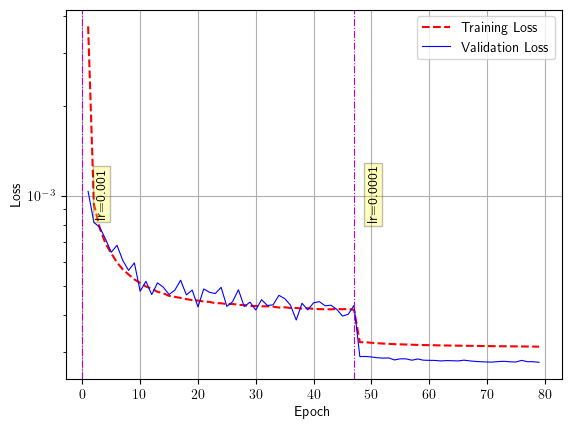

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

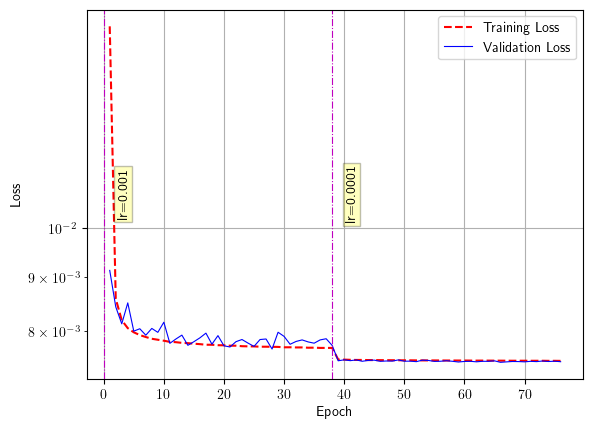

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

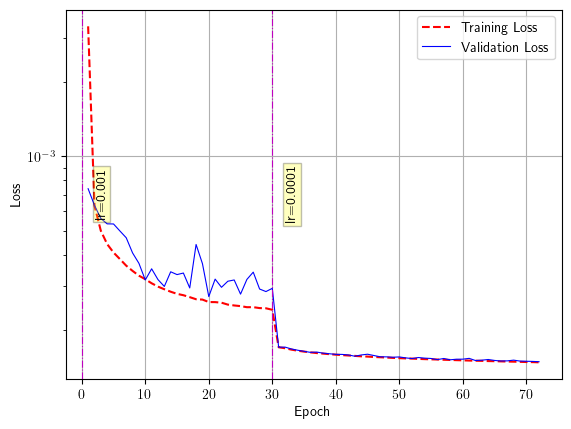

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

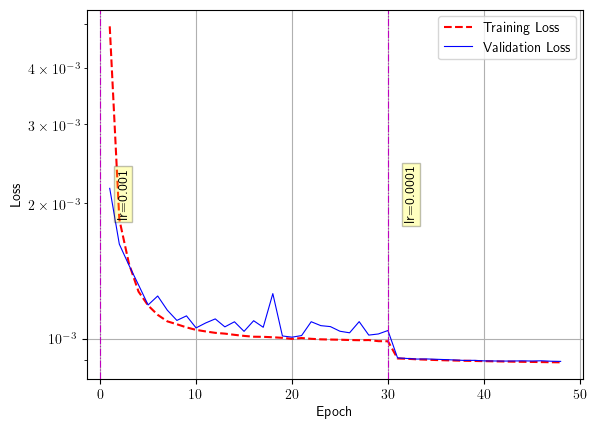

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

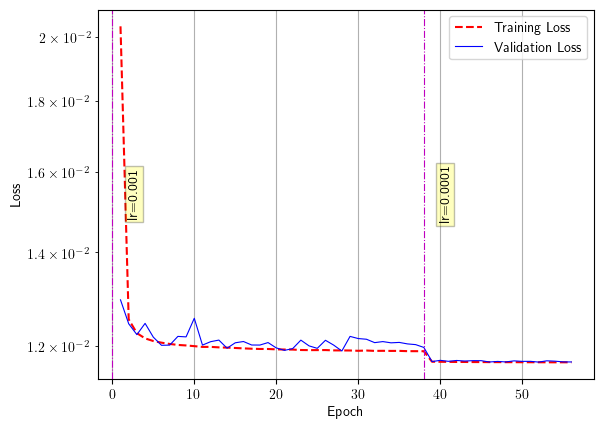

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

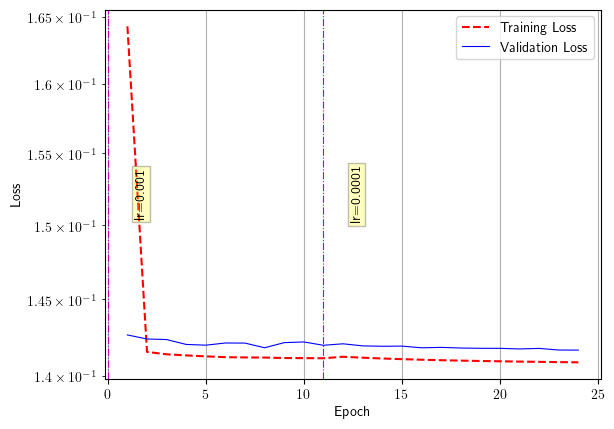

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

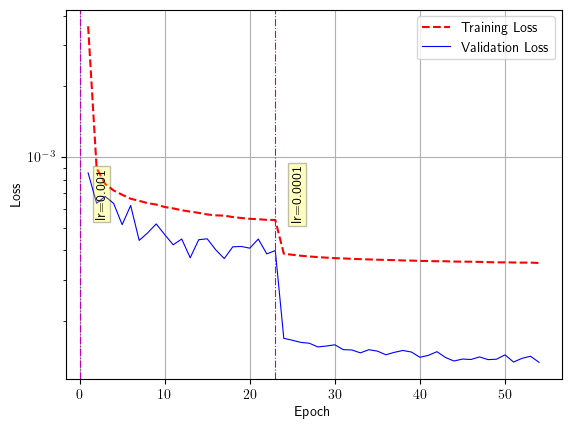

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

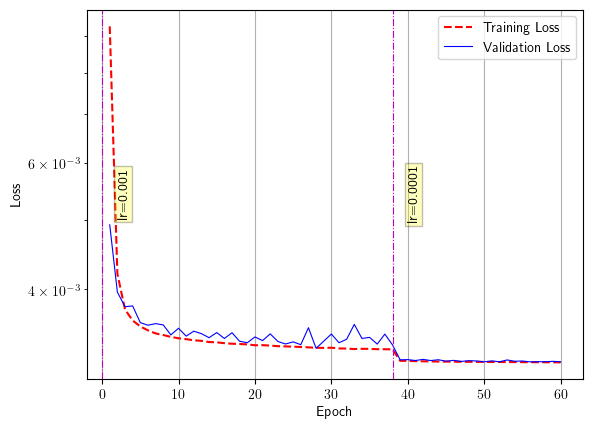

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

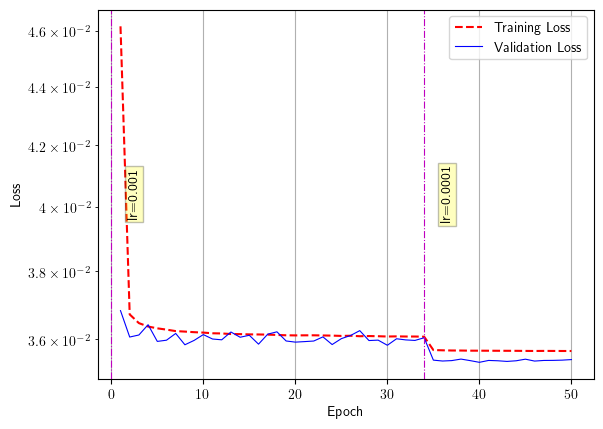

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

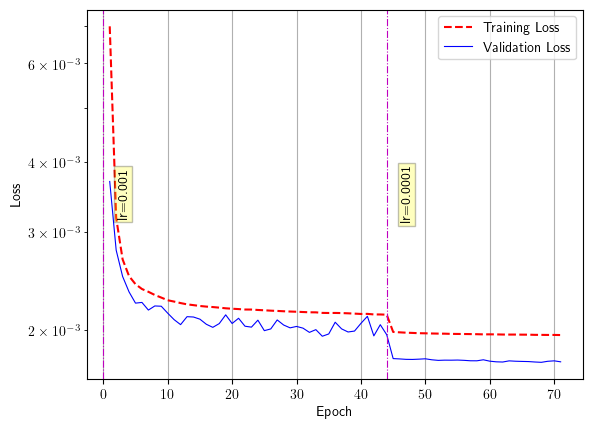

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

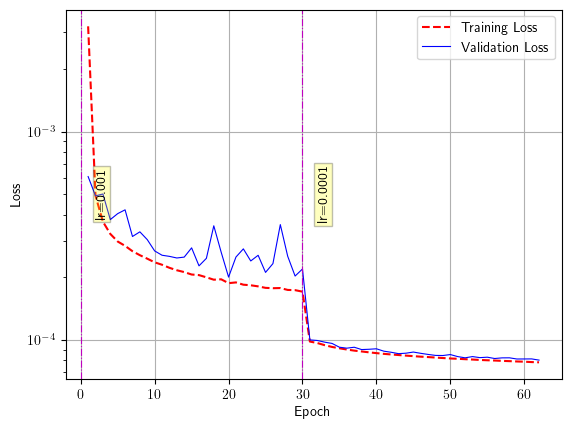

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

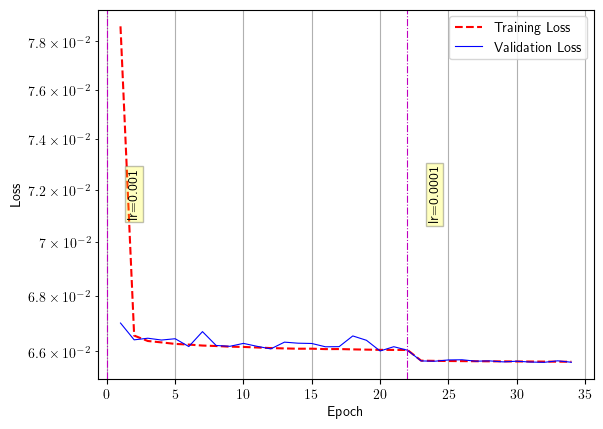

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

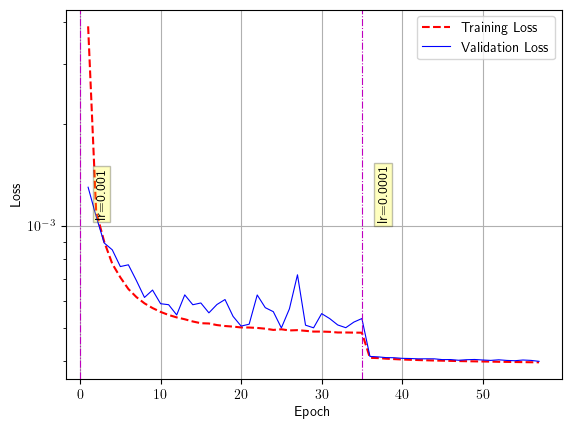

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

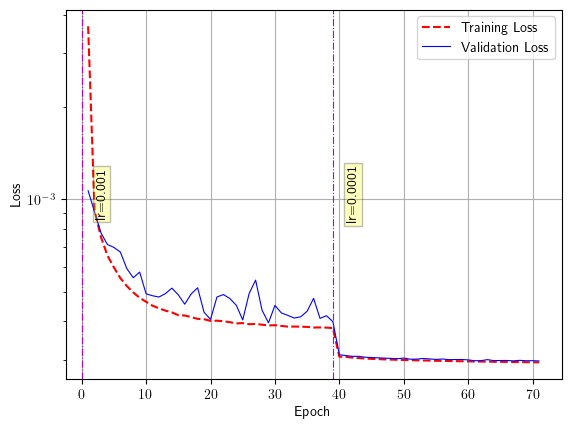

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

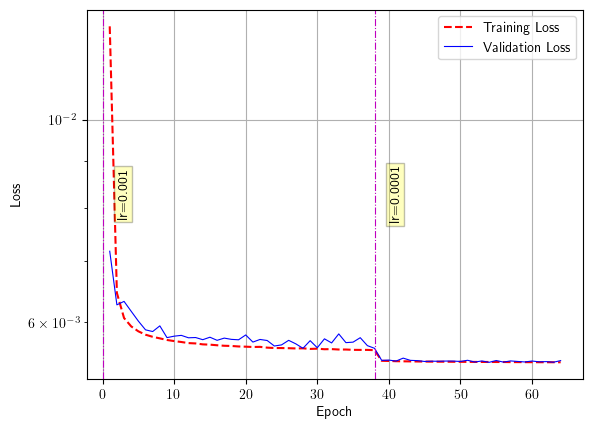

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

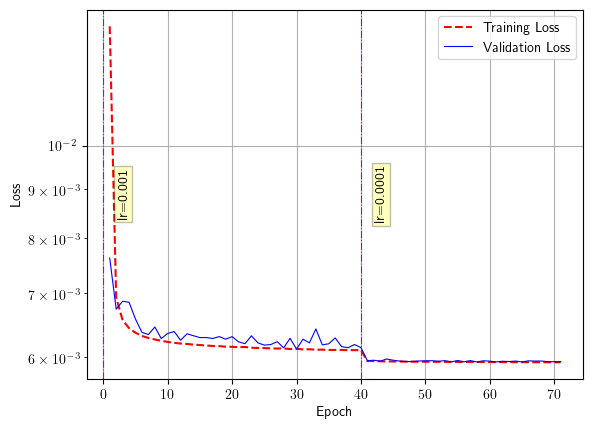

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

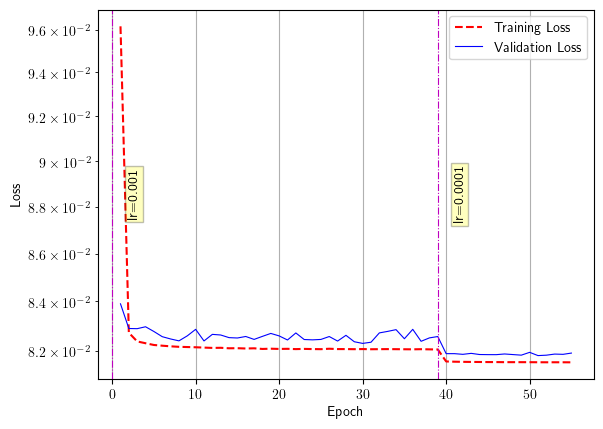

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

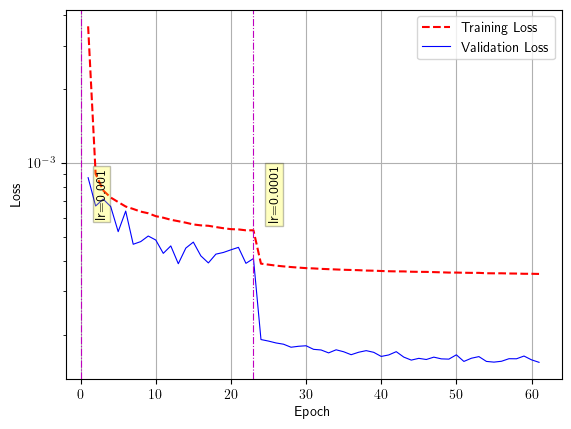

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

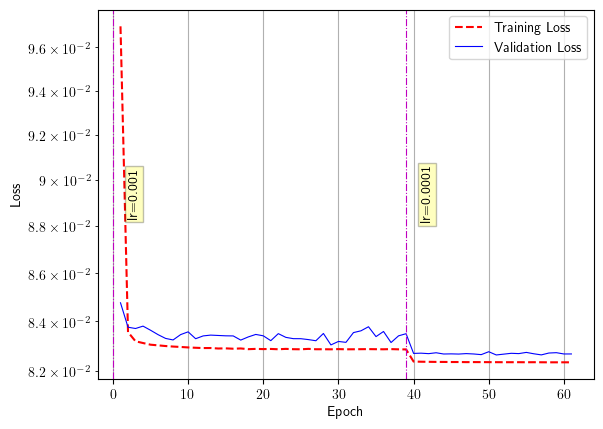

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

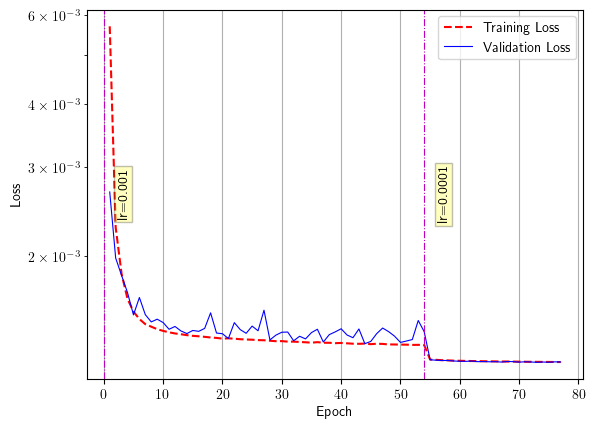

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

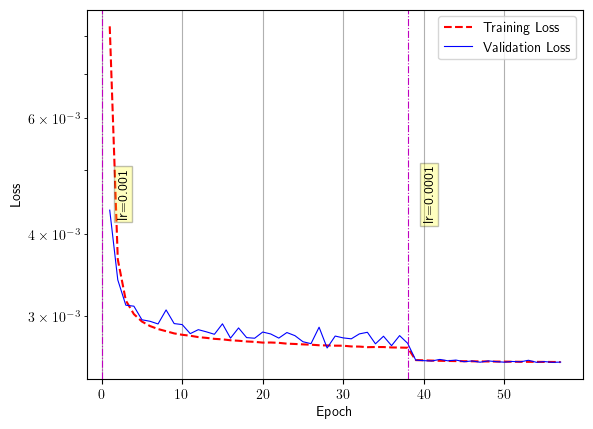

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

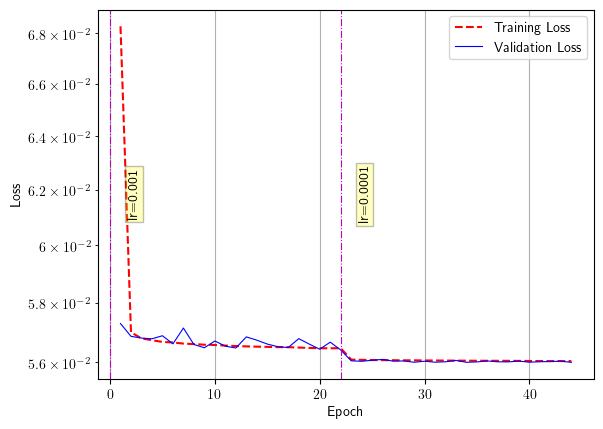

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

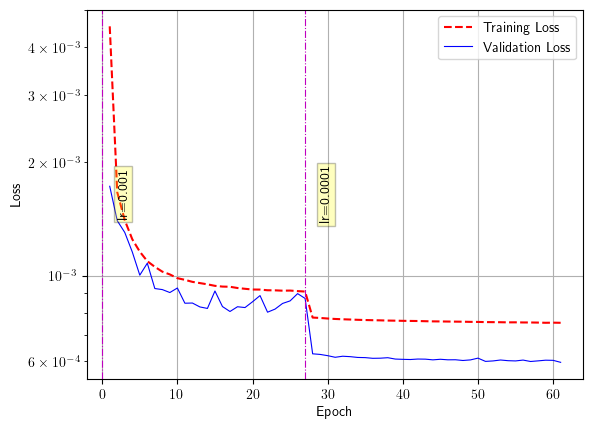

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

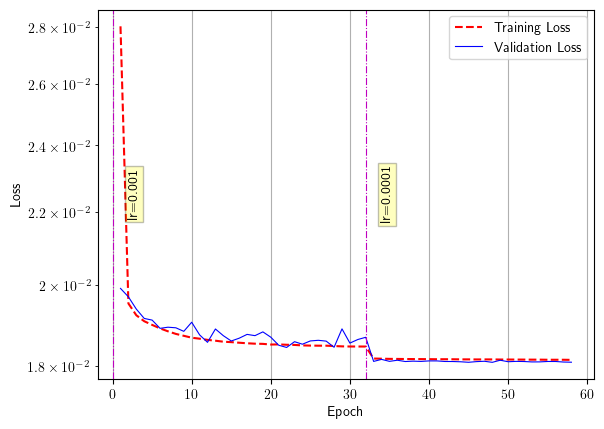

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

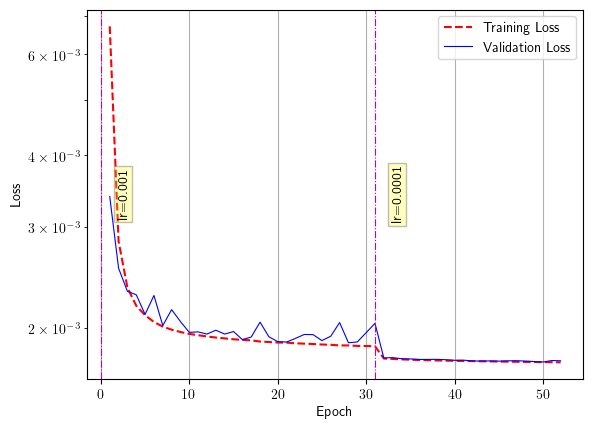

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
res = gp_minimize(
    optim_func,
    [fRMS_bounds, lambda_reg_bounds],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

In [34]:
res

          fun: 2.2373928004526533e-05
    func_vals: array([5.18036468e-05, 8.51293444e-04, 2.87953753e-05, 8.62651577e-05,
       1.11108820e-03, 4.31674123e-02, 6.96992356e-05, 2.83418049e-04,
       8.84085055e-03, 1.70752726e-04, 2.23739280e-05, 1.71200149e-02,
       5.30349353e-05, 4.31371227e-05, 5.47417148e-04, 5.90772077e-04,
       2.27442402e-02, 6.56749035e-05, 2.30573248e-02, 1.06392523e-04,
       2.44496274e-04, 1.57985277e-02, 9.39770034e-05, 2.48025893e-03,
       1.53213419e-04])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542),

In [35]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [36]:
optim_idx

10

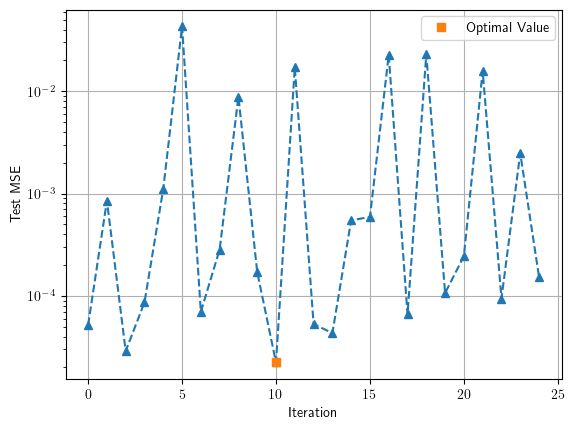

In [37]:
plt.semilogy(func_iters, '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('Test MSE')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/test_mse.png', bbox_inches='tight', dpi=300)
plt.show()

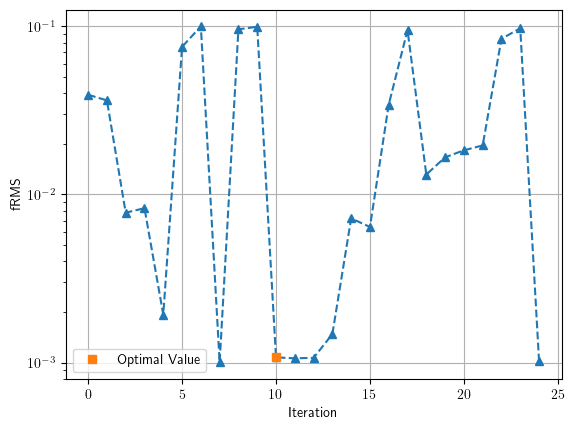

In [38]:
plt.semilogy(x_iters[:, 0], '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [x_iters[optim_idx, 0]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('fRMS')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/fRMS.png', bbox_inches='tight', dpi=300)
plt.show()

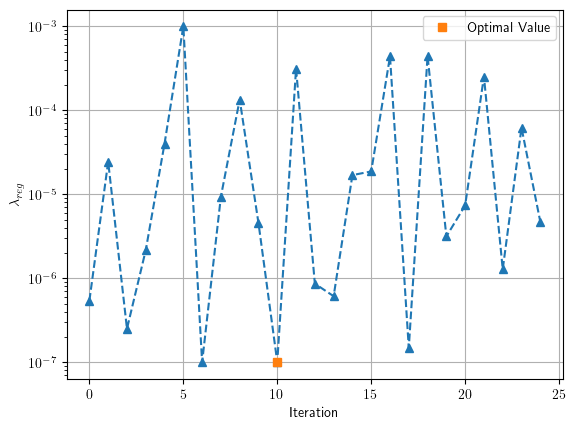

In [39]:
plt.semilogy(x_iters[:, 1], '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [x_iters[optim_idx, 1]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel(r'$\lambda_{reg}$')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/lambda_reg.png', bbox_inches='tight', dpi=300)
plt.show()

In [40]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

# KE and Dissipation